In [235]:
#-----------------------------------------------------------------------
# Code to generate hodographs and calculate SRH. Seeing how the 
# effect of friction combines with ground-relative (GR) wind speeds
# to influence SRH.
#-----------------------------------------------------------------------

In [236]:
#-----------------------------------------------------------------------
# Import stuff.
#-----------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import math as math
from pylab import rcParams
from metpy import calc
from metpy.units import units
import matplotlib.colors as colors



In [237]:
#-----------------------------------------------------------------------
# Define functions.
#-----------------------------------------------------------------------
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [238]:
#-----------------------------------------------------------------------
# Calculate 0–top-m SRH.
#   u = x-wind component
#   v = y-wind component
#   z = levels
#   cx = x-component of storm motion
#   cy = y-component of storm motion
#   bot = bottom of layer (m)
#   top = top of layer (m)
#-----------------------------------------------------------------------
def calc_srh(uf,vf,z,cx,cy,bot,top):
    
    srh = 0
    
    #-----------------------------------------------------------------------
    # Loop through levels.
    #-----------------------------------------------------------------------
    spacing = z[1] - z[0] # assume constant vertical resolution
    
    #-----------------------------------------------------------------------
    # If the bottom of the layer is the bottom level, skip the first level.
    #-----------------------------------------------------------------------    
    count = 1
    for i in np.arange(bot,top,spacing):
        dudz = (uf[count+1] - uf[count-1]) / (z[count+1] + z[count-1])
        dvdz = (vf[count+1] - vf[count-1]) / (z[count+1] + z[count-1])

        srh += ((uf[count+1] - cx) * (vf[count-1] - cy) - (uf[count-1] - cx) * (vf[count+1] - cy)) / 2

        count += 1
                    
    return(srh)

adding linear friction below 250 m
[   0.   25.   50.   75.  100.  200.  300. 1800.]


([<matplotlib.axis.YTick at 0x11c37df40>,
 <a list of 3 Text major ticklabel objects>)

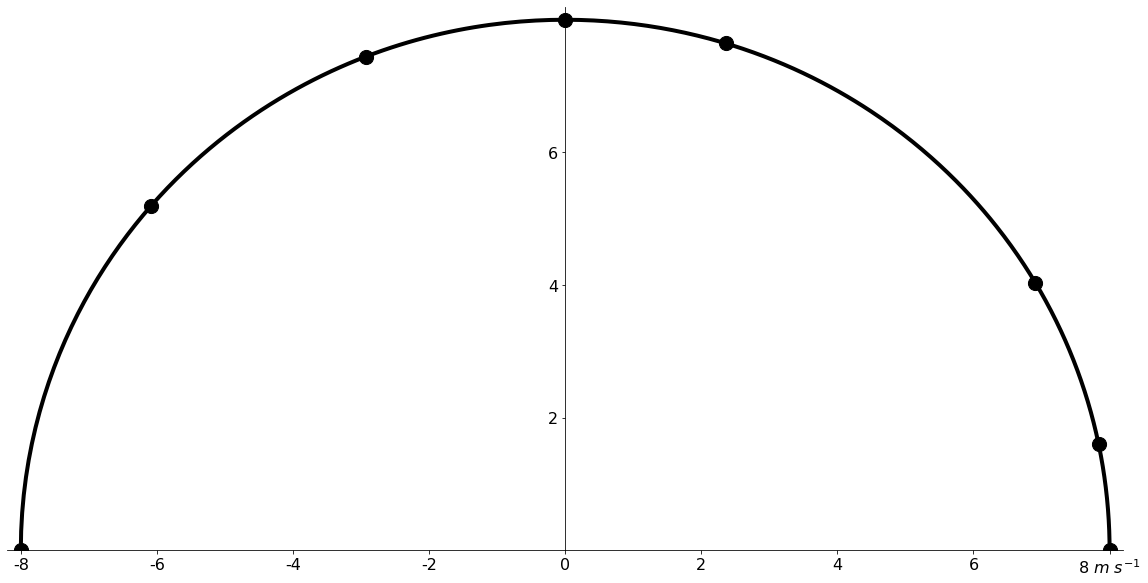

In [239]:
#-----------------------------------------------------------------------
# Create hodographs per Markowski and Richardson (2014). First, define
# heights and sounding parameters.
#-----------------------------------------------------------------------
heights = np.arange(0,18010,10)

A = 8 # hodograph radius (m/s)
H = 6000 # vertical scale (m)
m = 8 # compression scale (unitless)
z0 = 750 # height of maximum v (m)

num_heights = np.size(heights)

u = np.ones((num_heights))*np.nan
v = np.ones((num_heights))*np.nan

#-----------------------------------------------------------------------
# Create the base hodograph (without friction).
#-----------------------------------------------------------------------
count = 0
for z in np.arange(0,18010,10):
    #-----------------------------------------------------------------------
    # Calculate v from z.
    #-----------------------------------------------------------------------
    v[count] = A*m*z/H*np.exp(1-(m*z/H))
    
    #-----------------------------------------------------------------------
    # Calculate u from v and z.
    #-----------------------------------------------------------------------
    zdiff = z - z0
    
    if zdiff < 0:
        sgn = -1
    elif zdiff == 0:
        sgn = 0
    elif zdiff > 0:
        sgn = 1
        
    u[count] = sgn*(A**2 - v[count]**2)**(0.5)
        
    count += 1
    
#-----------------------------------------------------------------------
# Now add friction.
#-----------------------------------------------------------------------
u_fric = np.copy(u)
v_fric = np.copy(v)

dx = 6
dy = 5

u_fric2 = u_fric + dx
v_fric2 = v_fric + dy

fric_height = 250 # add friction effects below this level (m)
fric_index = int(fric_height/10)

fric = 'linear'

if fric == 'linear':
    print('adding linear friction below ' + str(fric_height) + ' m')
    count = 0
    for z in np.arange(0,fric_height,10):
        u_fric[count] = 0 + (z/fric_height)*u_fric[fric_index]
        v_fric[count] = 0 + (z/fric_height)*v_fric[fric_index]
                
        u_fric2[count] = 0 + (z/fric_height)*u_fric2[fric_index]
        v_fric2[count] = 0 + (z/fric_height)*v_fric2[fric_index]
                
        count += 1
        
        
    
#-----------------------------------------------------------------------
# Plot the hodograph.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 20,10

fig,ax = plt.subplots()

ax.plot(u,v,c='k',lw=4)
# plt.scatter(u_fric,v_fric)
# plt.scatter(u_fric2,v_fric2)

# --- make borders disappear ---
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('center')
ax.spines['right'].set_visible(False)

# --- add desired heights ---
height_dots = np.array([0.,250.,500.,750.,1000.,2000.,3000.,18000.]) # m
height_inds = height_dots/10.

print(height_inds)

for i in np.arange(0,len(height_inds)):
    ax.scatter(u[int(height_inds[i])],v[int(height_inds[i])],s=200,c='k',zorder=10)


# --- tweak axes ---
plt.xlim([-8.2,8.2])
plt.ylim([-0,8.2])
plt.xticks(np.arange(-8,10,2),labels=['-8','-6','-4','-2','0','2','4','6',r'8 $m$ $s^{-1}$'],fontsize=16)
plt.yticks(np.arange(2,8,2),fontsize=16)



In [240]:
#-----------------------------------------------------------------------
# Calculate SRH.
#-----------------------------------------------------------------------
srh = calc_srh(u,v,heights,0,0,0,1000)
srh1 = calc_srh(u_fric,v_fric,heights,0,0,0,1000)
srh2 = calc_srh(u_fric2,v_fric2,heights,dx,dy,0,1000)

print('Storm motion at origin without friction: SRH = ',srh)
print('Storm motion at origin with friction: SRH = ',srh1)
print('Storm motion off origin with friction: SRH = ',srh2)

Storm motion at origin without friction: SRH =  118.88338084675048
Storm motion at origin with friction: SRH =  74.80191100977554
Storm motion off origin with friction: SRH =  135.1615509594609


In [241]:
#-----------------------------------------------------------------------
# Loop through hodograph centers and calculate SRH at each one.
#-----------------------------------------------------------------------
left = -10
right = 10
bottom = -10
top = 10
step = 0.5

fric_height = 250
fric_index = int(fric_height/10)

allx = np.arange(left,right+step,step)
ally = np.arange(bottom,top+step,step)

num_x = np.size(allx)
num_y = np.size(ally)

srh_all = np.ones((num_x,num_y))*np.nan

for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        u1 = np.copy(u) + allx[i]
        v1 = np.copy(v) + ally[j]
                
        count = 0
        for k in np.arange(0,fric_height,10):
            u1[count] = 0 + (k/fric_height)*u1[fric_index]
            v1[count] = 0 + (k/fric_height)*v1[fric_index]

            count += 1
                        
        srh_all[i,j] = calc_srh(u1,v1,heights,allx[i],ally[j],0,250)
                                
print('Maximum SRH: ',np.max(srh_all))
print('Minimum SRH: ',np.min(srh_all))
            

Maximum SRH:  111.228087087608
Minimum SRH:  -109.83926245956718


(41,)
(41,)
(41, 41)


Text(0, 0.5, 'Center of half-circle hodograph (m/s)')

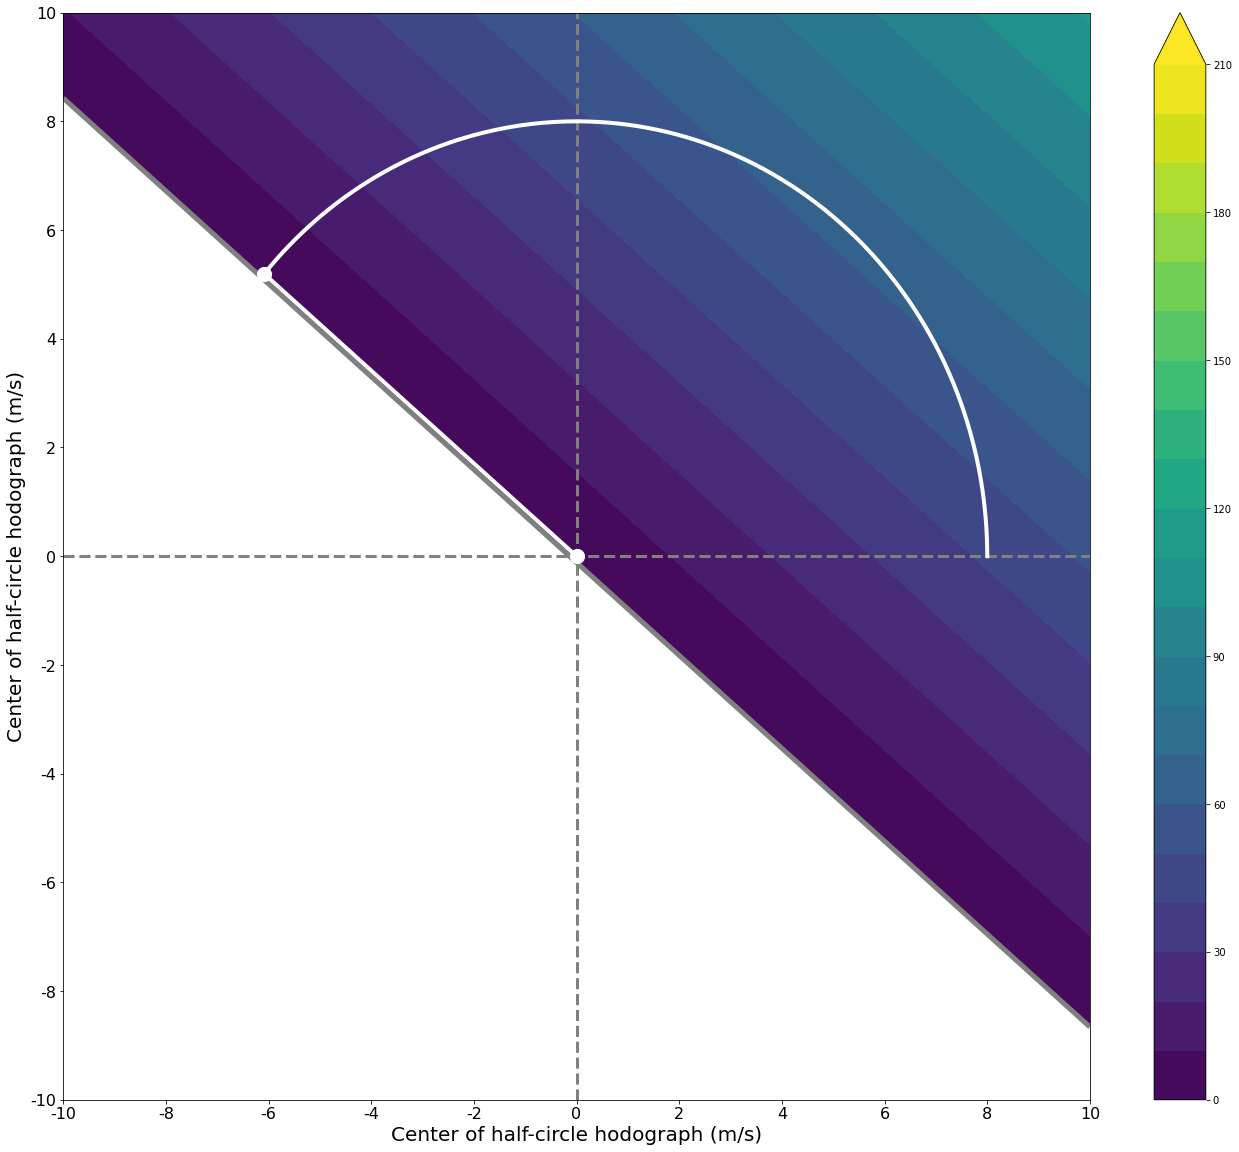

In [242]:
#-----------------------------------------------------------------------
# Contour SRH.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fix,ax = plt.subplots()

print(np.shape(allx))
print(np.shape(ally))
print(np.shape(srh_all))

levels = np.arange(0,220,10)
plt.contourf(allx,ally,srh_all.T,levels=levels,extend='max')
plt.colorbar()

# plt.plot(u_fric,v_fric,c='white',lw=3,ls='--')

# --- plot curved friction hodograph at origin ---
plt.plot(u_fric,v_fric,c='white',lw=4)

# --- highlight 250 m and origin ---
plt.scatter(u_fric[25],v_fric[25],c='white',s=200,zorder=5)
plt.scatter(0,0,c='white',s=200,zorder=5)

# --- highlight 0 isopleth ---
plt.contour(allx,ally,srh_all.T,levels=[0],colors='gray',linewidths=5)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='gray',lw=3)
plt.vlines(0,left,right,ls='--',colors='gray',lw=3)

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=16)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=16)

plt.xlabel('Center of half-circle hodograph (m/s)',fontsize=20)
plt.ylabel('Center of half-circle hodograph (m/s)',fontsize=20)




adding curvy friction below 100 m
[1.         0.76450951 0.57058902 0.41298632 0.2870724  0.18877033
 0.11449221 0.0610829  0.02577025 0.0061207 ]
[ 0.         -2.46274297 -4.29251882 ...  8.          8.
  8.        ]


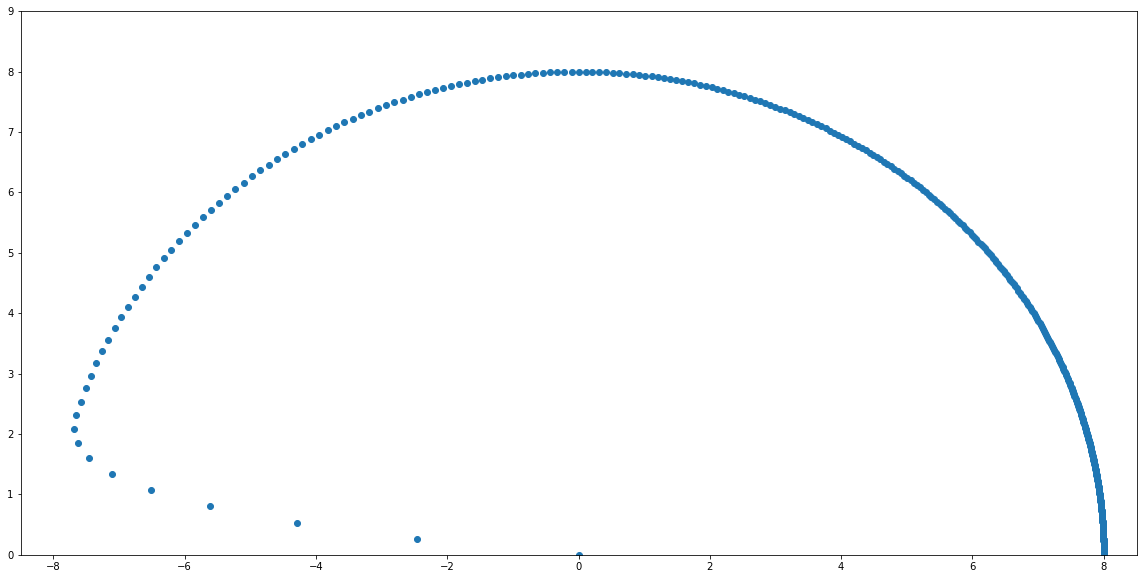

In [264]:
#-----------------------------------------------------------------------
# Now let's try some other ways to represent the friction layer.
#-----------------------------------------------------------------------
u2 = np.copy(u)
v2 = np.copy(v)

#-----------------------------------------------------------------------
# Add friction with some curvature. This will take some average of the
# half-circle and linear hodographs at each point below fric_height.
#-----------------------------------------------------------------------
fric = 'curvy'

fric_height = 100 # height that friction ends (m)
fric_index = int(fric_height/10) # index of fric_height

num_heights = np.size(np.arange(0,fric_height,10))
weight = np.ones((num_heights))*np.nan

if fric == 'curvy':
    print('adding curvy friction below ' + str(fric_height) + ' m')
    count = 0
    for z in np.arange(0,fric_height,10):
        #-----------------------------------------------------------------------
        # Calculate the linear component.
        #-----------------------------------------------------------------------
        u_l = 0 + (z/fric_height)*(u2[fric_index])
        v_l = 0 + (z/fric_height)*(v2[fric_index])
        
        #-----------------------------------------------------------------------
        # Calculate the half-circle component.
        #-----------------------------------------------------------------------
        u_c = u[count]
        v_c = v[count]
        
        #-----------------------------------------------------------------------
        # Calculate the weight (of the linear part).
        #-----------------------------------------------------------------------
        z0 = 0. # (m)
                
        weight[count] = (np.exp((fric_height-z)/fric_height)-1)/(np.exp(1)-1) * (1-(z/fric_height))
        
        #-----------------------------------------------------------------------
        # Combine the two using weights to get the final curvy components.
        #-----------------------------------------------------------------------
        u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
        v2[count] = v_l * weight[count] + v_c * (1 - weight[count])
                
        count += 1
        
print(weight)
print(u2)
        
#-----------------------------------------------------------------------
# Plot curvy friction.
#-----------------------------------------------------------------------
plt.scatter(u2,v2)

plt.xlim([-8.5,8.5])
plt.ylim([0,9])

#-----------------------------------------------------------------------
# Save a copy of this original hodograph.
#-----------------------------------------------------------------------
u_curvy = np.copy(u2)
v_curvy = np.copy(v2)


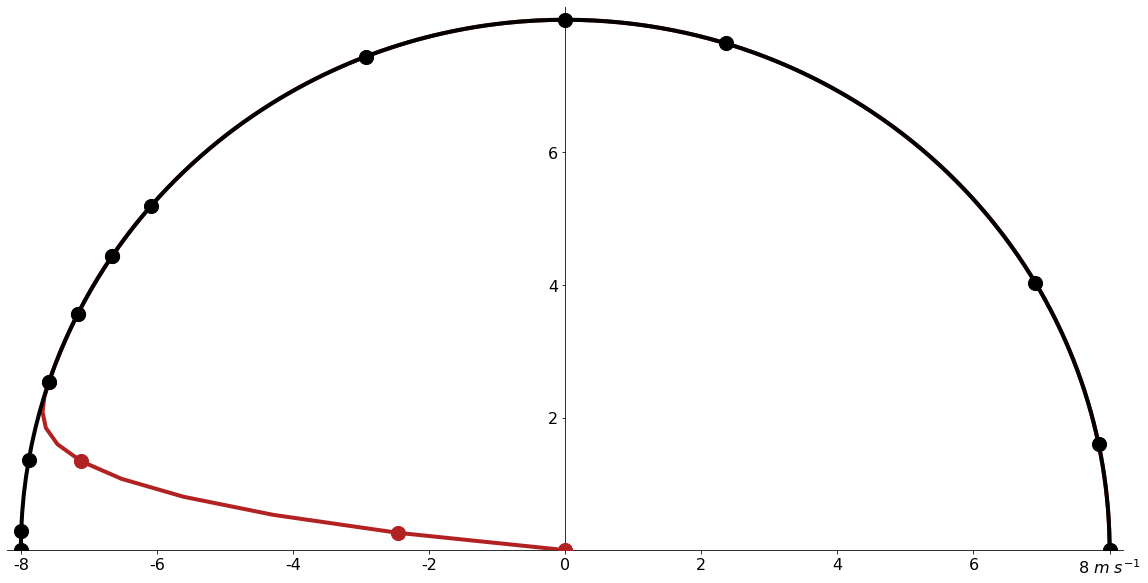

<Figure size 1440x720 with 0 Axes>

In [265]:
#-----------------------------------------------------------------------
# Plot the half-circle hodograph and this "curvy" hodograph together. 
# This is currently Fig. 1.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 20,10

fig,ax = plt.subplots()

#-----------------------------------------------------------------------
# Plot the "curvy" one, which only differs below z_fric.
#-----------------------------------------------------------------------
ax.plot(u_curvy,v_curvy,c='firebrick',lw=4)

# --- add a point at 0 m AGL ---
height_dots = np.array([0.,10.,50.,100.,150.,200.]) # m
height_inds = height_dots/10.

for i in np.arange(0,len(height_inds)):
    ax.scatter(u_curvy[int(height_inds[i])],v_curvy[int(height_inds[i])],s=200,c='firebrick',zorder=10)

#-----------------------------------------------------------------------
# And the half-circle.
#-----------------------------------------------------------------------
ax.plot(u,v,c='k',lw=4)

# --- make borders disappear ---
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('center')
ax.spines['right'].set_visible(False)

# --- add desired heights ---
height_dots = np.array([0.,10.,50.,100.,150.,200.,250.,500.,750.,1000.,2000.,3000.,18000.]) # m
height_inds = height_dots/10.

for i in np.arange(0,len(height_inds)):
    ax.scatter(u[int(height_inds[i])],v[int(height_inds[i])],s=200,c='k',zorder=10)
    
# --- tweak axes ---
plt.xlim([-8.2,8.2])
plt.ylim([-0,8.2])
plt.xticks(np.arange(-8,10,2),labels=['-8','-6','-4','-2','0','2','4','6',r'8 $m$ $s^{-1}$'],fontsize=16)
plt.yticks(np.arange(2,8,2),fontsize=16)

# --- save ---
# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/extras/hodo_100',dpi=300)
# plt.show()
# plt.clf()



In [266]:
#-----------------------------------------------------------------------
# Calculate SRH.
#-----------------------------------------------------------------------
srh = calc_srh(u,v,heights,0,0,0,250)
srhf = calc_srh(u_curvy,v_curvy,heights,0,0,0,250)

print('Storm motion at origin without friction: SRH = ',srh)
print('Storm motion at origin with friction: SRH = ',srhf)


Storm motion at origin without friction: SRH =  44.775882150995386
Storm motion at origin with friction: SRH =  35.83044079043064


In [267]:
#-----------------------------------------------------------------------
# Loop through hodograph centers and calculate SRH at each one.
#-----------------------------------------------------------------------
left = -10
right = 10
bottom = -10
top = 10
step = 0.5

# --- set friction-layer height here ---
fric_height = 100
fric_index = int(fric_height/10)
#---------------------------------------

num_heights = np.size(np.arange(0,fric_height,10))
weight = np.ones((num_heights))*np.nan

allx = np.arange(left,right+step,step)
ally = np.arange(bottom,top+step,step)

num_x = np.size(allx)
num_y = np.size(ally)

u_mw = np.ones((num_x,num_y))*np.nan
v_mw = np.ones((num_x,num_y))*np.nan
u_sm = np.ones((num_x,num_y))*np.nan
v_sm = np.ones((num_x,num_y))*np.nan

u_mw_circle = np.ones((num_x,num_y))*np.nan
v_mw_circle = np.ones((num_x,num_y))*np.nan
u_sm_circle = np.ones((num_x,num_y))*np.nan
v_sm_circle = np.ones((num_x,num_y))*np.nan

srh_all = np.ones((num_x,num_y))*np.nan
srh_all_mw = np.ones((num_x,num_y))*np.nan
srh_all_bunk = np.ones((num_x,num_y))*np.nan

srh_all_circle = np.ones((num_x,num_y))*np.nan
srh_all_mw_circle = np.ones((num_x,num_y))*np.nan
srh_all_bunk_circle = np.ones((num_x,num_y))*np.nan

u_l2 = np.ones((num_heights))*np.nan
v_l2 = np.ones((num_heights))*np.nan

p_blah = np.linspace(1000,10,np.size(np.arange(0,18010,10)))
z_blah = np.arange(0,18010,10)

for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        # --- u2 and v2 will become the hodo with friction ---
        u2 = np.copy(u) + allx[i]
        v2 = np.copy(v) + ally[j]
        
        # --- u_circle and v_circle will remain the full half-circle ---
        u_circle = np.copy(u) + allx[i]
        v_circle = np.copy(v) + ally[j]
                
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate the linear component.
            #-----------------------------------------------------------------------
            u_l = 0 + (z/fric_height)*u2[fric_index]
            v_l = 0 + (z/fric_height)*v2[fric_index]
            
            if allx[i] == 0 and ally[j] == 0:
                u_l2[count] = u_l
                v_l2[count] = v_l

            #-----------------------------------------------------------------------
            # Calculate the half-circle component.
            #-----------------------------------------------------------------------
            u_c = u2[count]
            v_c = v2[count]

            #-----------------------------------------------------------------------
            # Calculate the weight (of the linear part).
            #-----------------------------------------------------------------------
            weight[count] = (np.exp((fric_height-z)/fric_height)-1)/(np.exp(1)-1) * (1-(z/fric_height))

            #-----------------------------------------------------------------------
            # Combine the two using weights to get the final curvy components.
            #-----------------------------------------------------------------------
            u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
            v2[count] = v_l * weight[count] + v_c * (1 - weight[count])

            count += 1
            
        #-----------------------------------------------------------------------
        # Now that we have the full wind profile (u2,v2), calculate Bunkers-
        # right motion.
        #-----------------------------------------------------------------------
        p_blah_units = p_blah * units.millibar
        u2_units = u2 * units.meter / units.second
        v2_units = v2 * units.meter / units.second
        z_blah_units = z_blah * units.meter
        
        sm = calc.bunkers_storm_motion(p_blah_units,u2_units,v2_units,z_blah_units)
        u_sm[i,j] = sm[0][0].magnitude
        v_sm[i,j] = sm[0][1].magnitude
        
        # --- repeat for the profile without friction ---
        u_circle_units = u_circle * units.meter / units.second
        v_circle_units = v_circle * units.meter / units.second
        
        sm_circle = calc.bunkers_storm_motion(p_blah_units,u_circle_units,v_circle_units,z_blah_units)
        u_sm_circle[i,j] = sm_circle[0][0].magnitude
        v_sm_circle[i,j] = sm_circle[0][1].magnitude
        
        #-----------------------------------------------------------------------
        # Also calculate the mean wind.
        #-----------------------------------------------------------------------
        u_mw[i,j] = np.mean(u2[:600])
        v_mw[i,j] = np.mean(v2[:600])
        
        # --- repeat for the profile without friction ---
        u_mw_circle[i,j] = np.mean(u_circle[:600])
        v_mw_circle[i,j] = np.mean(v_circle[:600])
                    
        if allx[i] == 2 and ally[j] == 3:
            ut1 = np.copy(u2)
            vt1 = np.copy(v2)
            
            i_int1 = i
            j_int1 = j
            
        if allx[i] == -3 and ally[j] == 2:
            ut2 = np.copy(u2)
            vt2 = np.copy(v2)
            
            i_int2 = i
            j_int2 = j
            
        if allx[i] == 0 and ally[j] == 0:
            u_curvy = np.copy(u2)
            v_curvy = np.copy(v2)
            
            i_int = i
            j_int = j
                                    
        srh_all[i,j] = calc_srh(u2,v2,heights,allx[i],ally[j],0,250)
        srh_all_mw[i,j] = calc_srh(u2,v2,heights,u_mw[i,j],v_mw[i,j],0,250) # storm motion = 0–6 mean wind
        srh_all_bunk[i,j] = calc_srh(u2,v2,heights,u_sm[i,j],v_sm[i,j],0,250)
        
        srh_all_circle[i,j] = calc_srh(u_circle,v_circle,heights,allx[i],ally[j],0,250)
        srh_all_mw_circle[i,j] = calc_srh(u_circle,v_circle,heights,u_mw_circle[i,j],v_mw_circle[i,j],0,250) # storm motion = 0–6 mean wind
        srh_all_bunk_circle[i,j] = calc_srh(u_circle,v_circle,heights,u_sm_circle[i,j],v_sm_circle[i,j],0,250)                  

print('PROFILE WITH FRICTION')
print('Motion at center of half-circle...')
print('Maximum SRH: ',np.max(srh_all))
print('Minimum SRH: ',np.min(srh_all))

print('Bunkers...')
print('Maximum SRH: ',np.max(srh_all_bunk))
print('Minimum SRH: ',np.min(srh_all_bunk))

print('Mean wind...')
print('Maximum SRH: ',np.max(srh_all_mw))
print('Minimum SRH: ',np.min(srh_all_mw))

print('')

print('PROFILE WITHOUT FRICTION')
print('Motion at center of half-circle...')
print('Maximum SRH: ',np.max(srh_all_circle))
print('Minimum SRH: ',np.min(srh_all_circle))

srh_circle_center = np.max(srh_all_circle)

print('Bunkers...')
print('Maximum SRH: ',np.max(srh_all_bunk_circle))
print('Minimum SRH: ',np.min(srh_all_bunk_circle))

srh_circle_bunk = np.max(srh_all_bunk_circle)

print('Mean wind...')
print('Maximum SRH: ',np.max(srh_all_mw_circle))
print('Minimum SRH: ',np.min(srh_all_mw_circle))

srh_circle_mw = np.max(srh_all_mw_circle)

            

PROFILE WITH FRICTION
Motion at center of half-circle...
Maximum SRH:  113.39482105605957
Minimum SRH:  -41.73393947519827
Bunkers...
Maximum SRH:  170.89117484728644
Minimum SRH:  -102.86290791288184
Mean wind...
Maximum SRH:  203.18203864066686
Minimum SRH:  -47.84069254654821

PROFILE WITHOUT FRICTION
Motion at center of half-circle...
Maximum SRH:  44.77588215099541
Minimum SRH:  44.77588215099537
Bunkers...
Maximum SRH:  67.64359030934656
Minimum SRH:  67.64359030934651
Mean wind...
Maximum SRH:  68.02138878791975
Minimum SRH:  68.02138878791969


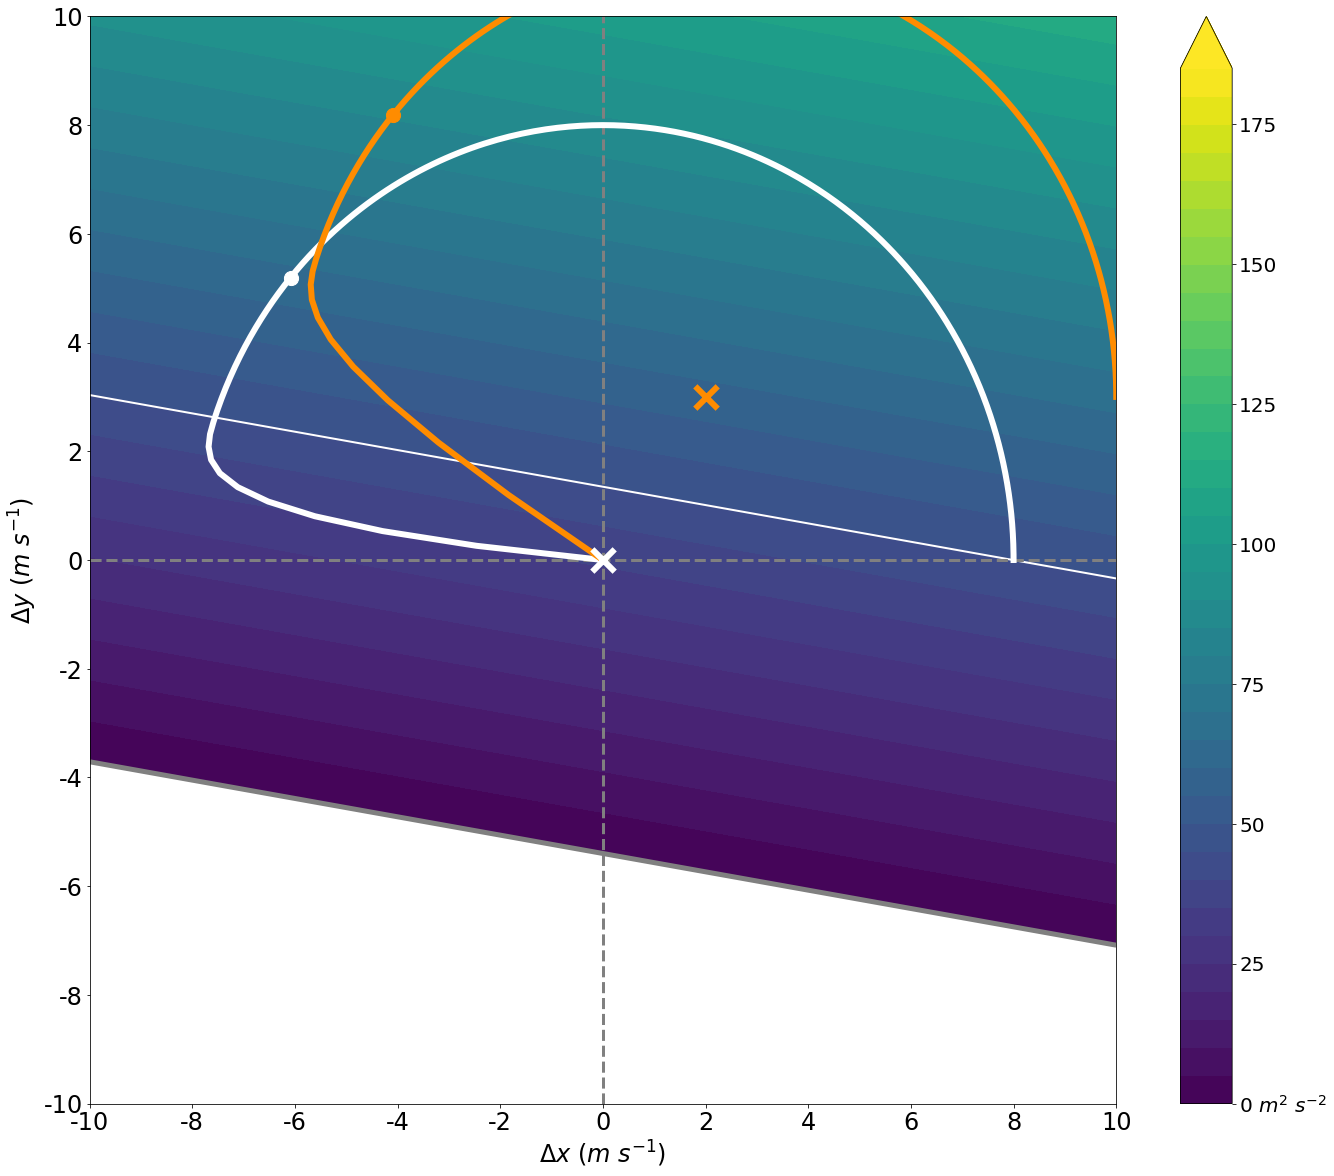

<Figure size 1656x1440 with 0 Axes>

In [268]:
#-----------------------------------------------------------------------
# Contour SRH.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

levels = np.arange(0,190,5)
cax = plt.contourf(allx,ally,srh_all.T,levels=levels,extend='max')

# --- customize colorbar ---
cbar = fig.colorbar(cax,ticks=np.arange(0,200,25))
cbarlabels = [r'0 $m^{2}$ $s^{-2}$','25','50','75','100','125','150','175']
# cbar.ax.set_yticks(np.arange(0,250,50))
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

# --- plot curved friction hodograph at origin ---
plt.plot(u_curvy,v_curvy,c='white',lw=6)

# --- plot curved friction hodograph at another point of interest ---
plt.plot(ut1,vt1,c='darkorange',lw=6)

# --- plot linear hodograph from 0 to zfric ---
# plt.plot(u_l2,v_l2,c='white',ls=(0,(3,3)),lw=4)

# --- highlight 250 m and origin for base profile ---
plt.scatter(u_curvy[25],v_curvy[25],c='white',s=200,zorder=5)
plt.scatter(0,0,c='white',marker='x',linewidth=6,s=500,zorder=5) 

# --- highlight 250 m and origin for the second profile of interest ---
plt.scatter(ut1[25],vt1[25],c='darkorange',s=200,zorder=5)
plt.scatter(2,3,c='darkorange',marker='x',linewidth=6,s=500,zorder=5)

# --- highlight 0 isopleth ---
plt.contour(allx,ally,srh_all.T,levels=[0],colors='gray',linewidths=5)

# --- highlight SRH for the non-friction profile ---
plt.contour(allx,ally,srh_all.T,levels=[srh_circle_center],colors='white',linewidths=2)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='gray',lw=3)
plt.vlines(0,left,right,ls='--',colors='gray',lw=3)

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

# --- set axis limits ---
plt.ylim([-10,10])
plt.xlim([-10,10])

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=24)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=24)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/extras/srh_center_100',dpi=300)
# plt.show()
# plt.clf()









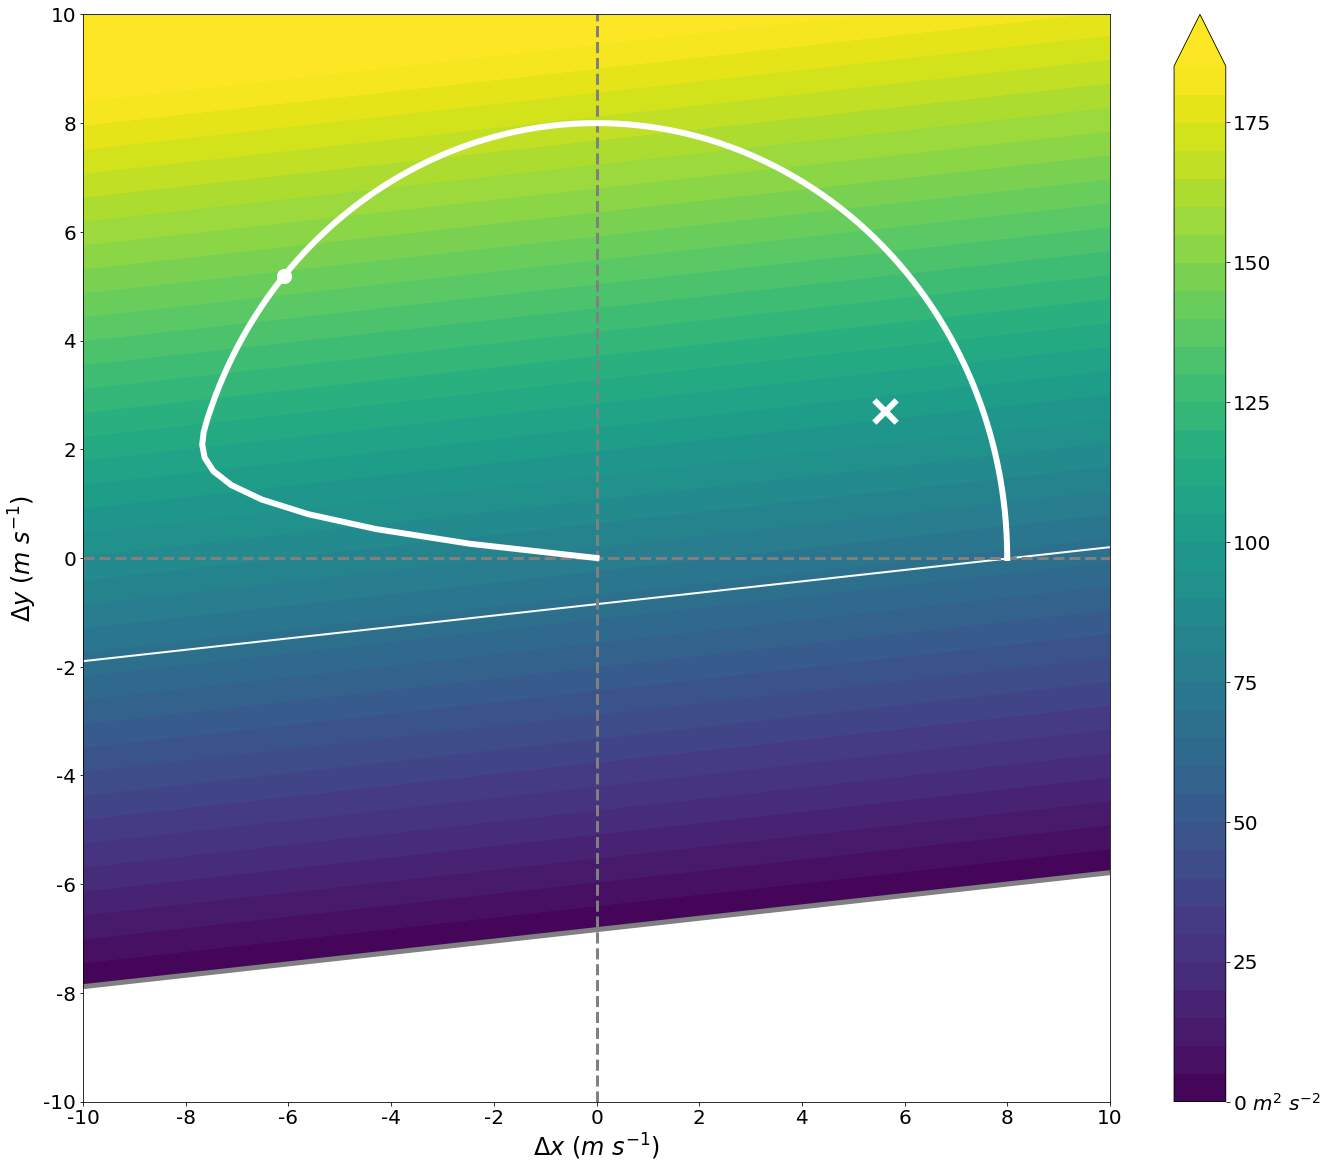

<Figure size 1656x1440 with 0 Axes>

In [269]:
#-----------------------------------------------------------------------
# Now do the same but for SRH assuming motion along the mean wind.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

levels = np.arange(0,190,5)
cax = plt.contourf(allx,ally,srh_all_mw.T,levels=levels,extend='max')

# --- customize colorbar ---
cbar = fig.colorbar(cax,ticks=np.arange(0,200,25))
cbarlabels = [r'0 $m^{2}$ $s^{-2}$','25','50','75','100','125','150','175']
# cbar.ax.set_yticks(np.arange(0,250,50))
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

# plt.plot(u_fric,v_fric,c='white',lw=3,ls='--')

# --- plot curved friction hodograph at origin ---
plt.plot(u_curvy,v_curvy,c='white',lw=6)

# # --- plot a case with more SRH ---
# plt.plot(ut1,vt1,c='black',lw=4)
# plt.scatter(u_sm[i_int1,j_int1],v_sm[i_int1,j_int1],c='black',s=200,zorder=5)

# # --- plot a case with less SRH ---
# plt.plot(ut2,vt2,c='black',lw=4)
# plt.scatter(u_sm[i_int2,j_int2],v_sm[i_int2,j_int2],c='black',s=200,zorder=5)

# --- highlight 250 m and origin ---
plt.scatter(u_curvy[25],v_curvy[25],c='white',s=200,zorder=5)

# --- plot Bunkers motion for this hodograph ---
plt.scatter(u_mw[i_int,j_int],v_mw[i_int,j_int],marker='x',linewidth=6,c='white',s=500,zorder=5)

# --- highlight 0 isopleth ---
plt.contour(allx,ally,srh_all_mw.T,levels=[0],colors='gray',linewidths=5)

# --- highlight SRH for the non-friction profile ---
plt.contour(allx,ally,srh_all_mw.T,levels=[srh_circle_mw],colors='white',linewidths=2)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='gray',lw=3)
plt.vlines(0,left,right,ls='--',colors='gray',lw=3)

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/PostDoc/Research/GRwindFrictionSRH/plots/halfcircle_srh_mw',dpi=300)
# plt.show()
# plt.clf()





67.64359030934656


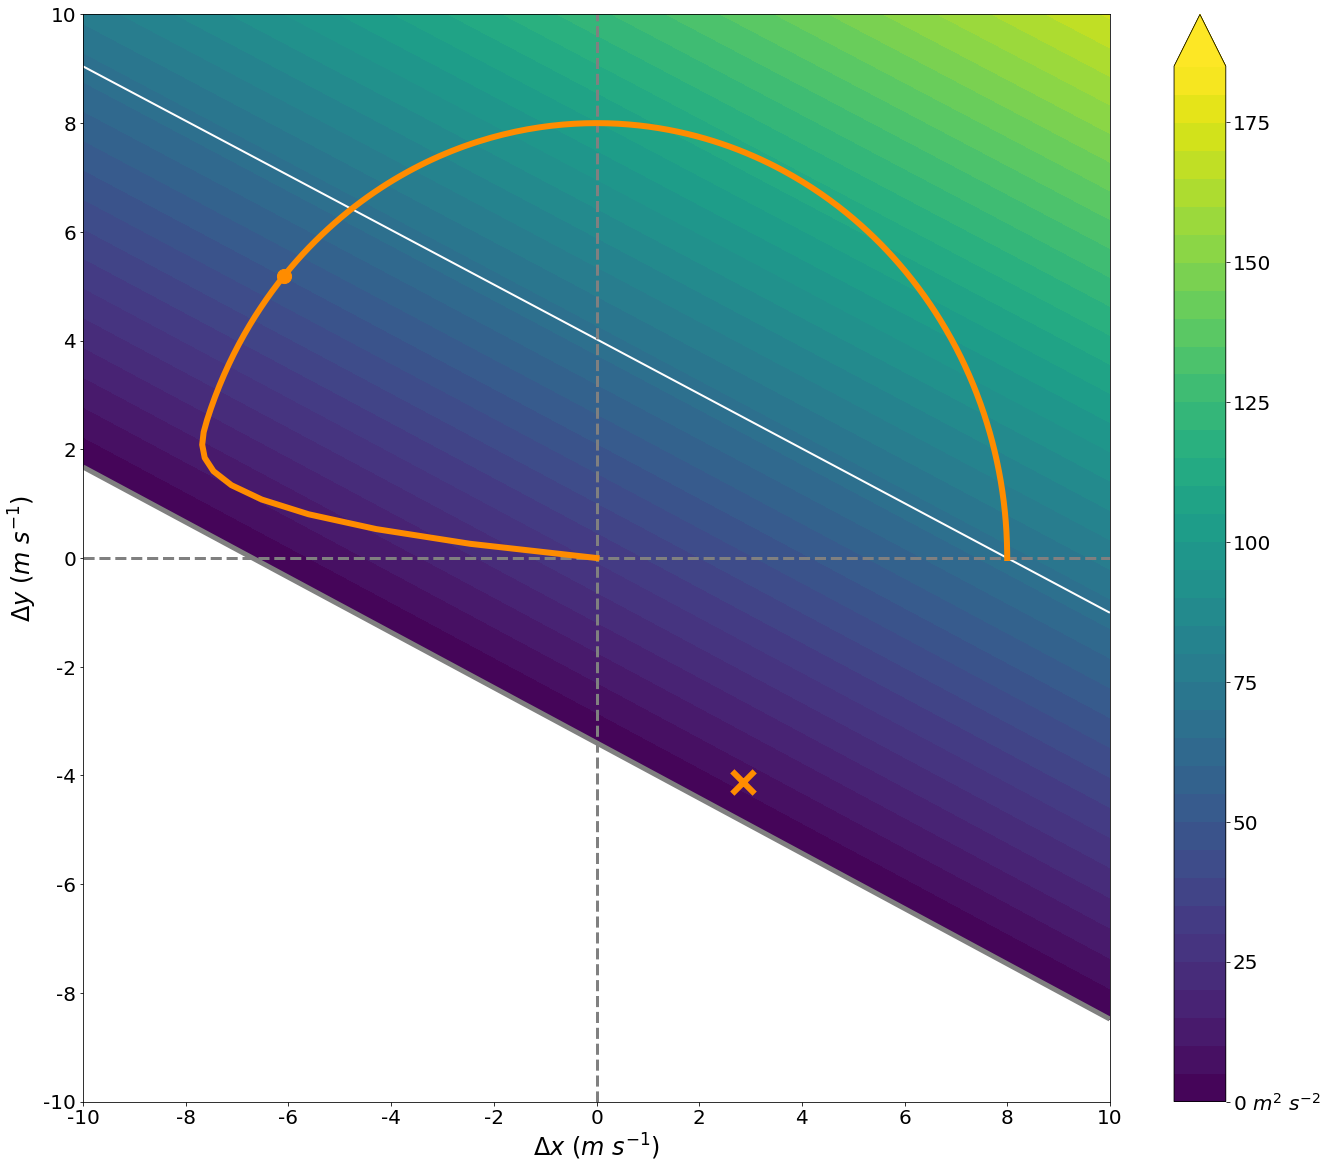

<Figure size 1656x1440 with 0 Axes>

In [270]:
#-----------------------------------------------------------------------
# Now do the same but for SRH assuming Bunkers-right motion.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

levels = np.arange(0,190,5)
cax = plt.contourf(allx,ally,srh_all_bunk.T,levels=levels,extend='max')

# --- customize colorbar ---
cbar = fig.colorbar(cax,ticks=np.arange(0,200,25))
cbarlabels = [r'0 $m^{2}$ $s^{-2}$','25','50','75','100','125','150','175']
# cbar.ax.set_yticks(np.arange(0,250,50))
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

# plt.plot(u_fric,v_fric,c='white',lw=3,ls='--')

# --- plot curved friction hodograph at origin ---
plt.plot(u_curvy,v_curvy,c='darkorange',lw=6)

# # --- plot a case with more SRH ---
# plt.plot(ut1,vt1,c='black',lw=4)
# plt.scatter(u_sm[i_int1,j_int1],v_sm[i_int1,j_int1],c='black',s=200,zorder=5)

# # --- plot a case with less SRH ---
# plt.plot(ut2,vt2,c='black',lw=4)
# plt.scatter(u_sm[i_int2,j_int2],v_sm[i_int2,j_int2],c='black',s=200,zorder=5)

# --- highlight 250 m and origin ---
plt.scatter(u_curvy[25],v_curvy[25],c='darkorange',s=200,zorder=5)

# --- plot Bunkers motion for this hodograph ---
plt.scatter(u_sm[i_int,j_int],v_sm[i_int,j_int],marker='x',linewidth=6,c='darkorange',s=500,zorder=5)

# --- highlight 0 isopleth ---
plt.contour(allx,ally,srh_all_bunk.T,levels=[0],colors='gray',linewidths=5)

# --- highlight SRH for the non-friction profile ---
print(srh_circle_bunk)
plt.contour(allx,ally,srh_all_bunk.T,levels=[srh_circle_bunk],colors='white',linewidths=2)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='gray',lw=3)
plt.vlines(0,left,right,ls='--',colors='gray',lw=3)

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

# --- axis limits ---
plt.xlim([-10,10])
plt.ylim([-10,10])

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/extras/srh_rm_100',dpi=300)
# plt.show()
# plt.clf()


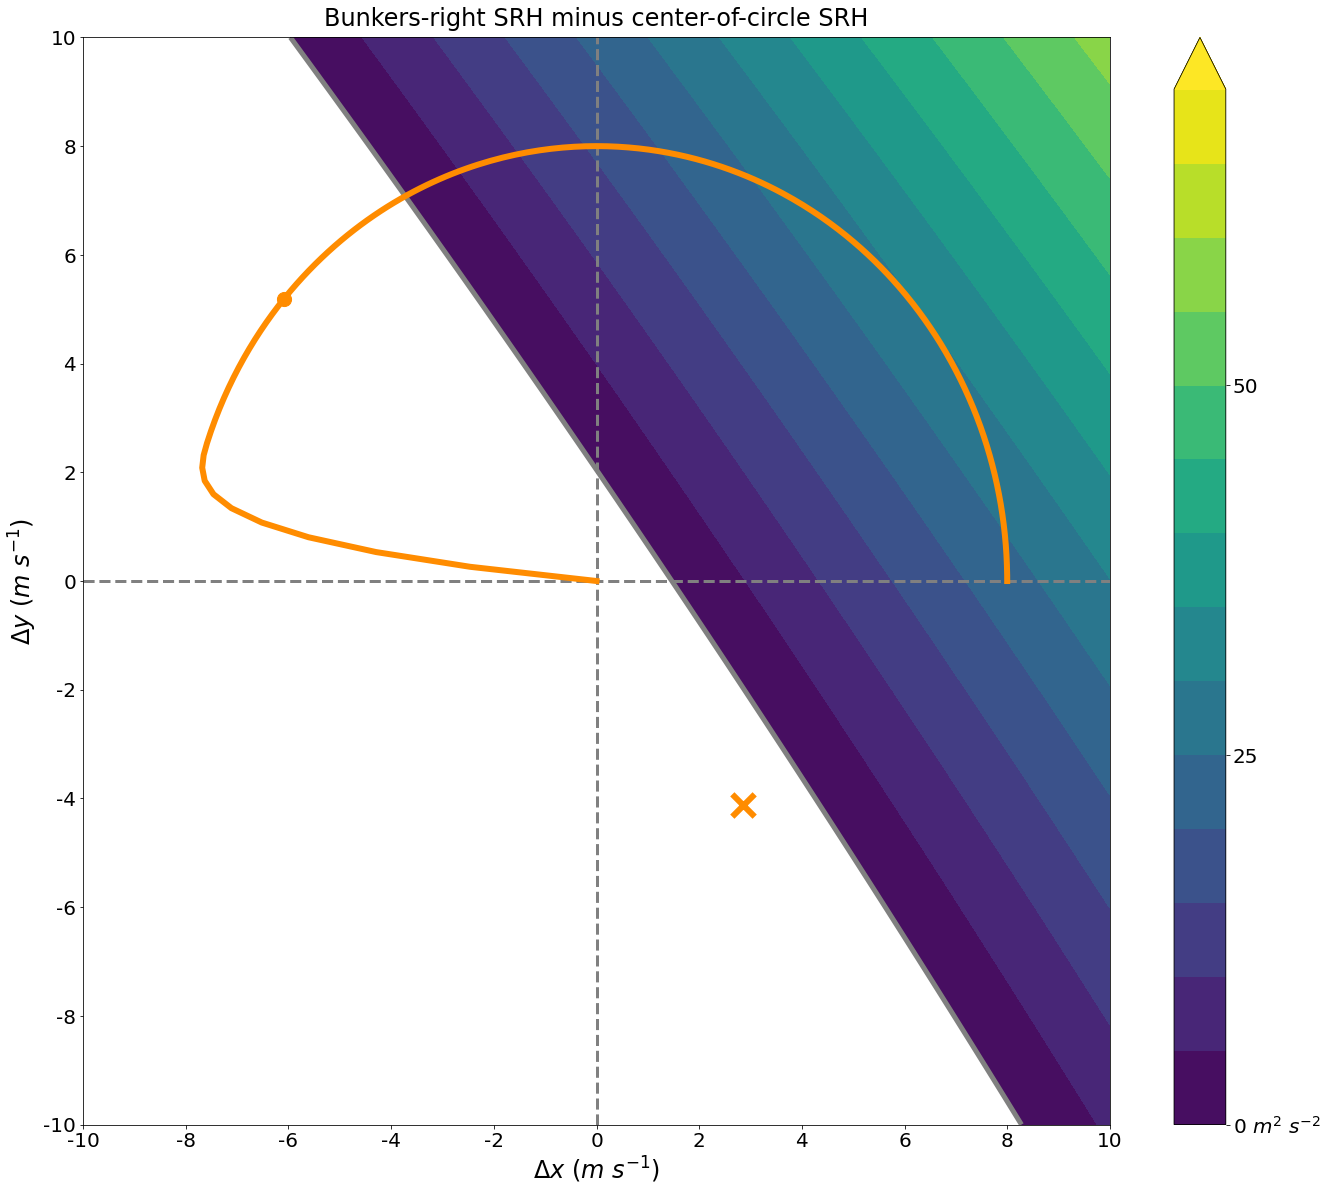

<Figure size 1656x1440 with 0 Axes>

In [271]:
#-----------------------------------------------------------------------
# Plot SRH from Bunkers-right MINUS SRH from the half-circle storm-
# motion assumptions (Fig. 7 minus Fig. 3 in v1).
#-----------------------------------------------------------------------
srh_diff = srh_all_bunk - srh_all

#-----------------------------------------------------------------------
# And plot the DIFFERENCE.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()
fig.patch.set_facecolor('white')

levels = np.arange(0,75,5)
cax = plt.contourf(allx,ally,srh_diff.T,levels=levels,extend='max')

# --- customize colorbar ---
cbar = fig.colorbar(cax,ticks=np.arange(0,200,25))
cbarlabels = [r'0 $m^{2}$ $s^{-2}$','25','50','75','100','125','150','175']
# cbar.ax.set_yticks(np.arange(0,250,50))
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

# plt.plot(u_fric,v_fric,c='white',lw=3,ls='--')

# --- plot curved friction hodograph at origin ---
plt.plot(u_curvy,v_curvy,c='darkorange',lw=6)

# # --- plot a case with more SRH ---
# plt.plot(ut1,vt1,c='black',lw=4)
# plt.scatter(u_sm[i_int1,j_int1],v_sm[i_int1,j_int1],c='black',s=200,zorder=5)

# # --- plot a case with less SRH ---
# plt.plot(ut2,vt2,c='black',lw=4)
# plt.scatter(u_sm[i_int2,j_int2],v_sm[i_int2,j_int2],c='black',s=200,zorder=5)

# --- highlight 250 m and origin ---
plt.scatter(u_curvy[25],v_curvy[25],c='darkorange',s=200,zorder=5)

# --- plot Bunkers motion for this hodograph ---
plt.scatter(u_sm[i_int,j_int],v_sm[i_int,j_int],marker='x',linewidth=6,c='darkorange',s=500,zorder=5)

# --- highlight 0 isopleth ---
plt.contour(allx,ally,srh_diff.T,levels=[0],colors='gray',linewidths=5)

# # --- highlight SRH for the non-friction profile ---
# print(srh_circle_bunk)
# plt.contour(allx,ally,srh_all_bunk.T,levels=[srh_circle_bunk],colors='white',linewidths=2)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='gray',lw=3)
plt.vlines(0,left,right,ls='--',colors='gray',lw=3)

# --- axis limits ---
plt.title('Bunkers-right SRH minus center-of-circle SRH',fontsize=24,y=1.005)

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

# --- axis limits ---
plt.xlim([-10,10])
plt.ylim([-10,10])

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/PostDoc/Research/GRwindFrictionSRH/plots/halfcircle_srh_bunkers',dpi=300)
# plt.show()
# plt.clf()


In [272]:
#-----------------------------------------------------------------------
# Now loop through and calculate mean horizontal shear magnitude, 
# storm-relative wind magnitude, and the angle between the two in the
# friction layer (0–250 m AGL) for all delta x/y.
#
# This section is for an assumed storm motion at the center of the
# half-circle.
#-----------------------------------------------------------------------
hvort_x_avg = np.ones((num_x,num_y))*np.nan
hvort_y_avg = np.ones((num_x,num_y))*np.nan
hvort_mag_avg = np.ones((num_x,num_y))*np.nan

srwind_x_avg = np.ones((num_x,num_y))*np.nan
srwind_y_avg = np.ones((num_x,num_y))*np.nan
srwind_mag_avg = np.ones((num_x,num_y))*np.nan

angle_avg = np.ones((num_x,num_y))*np.nan


#-----------------------------------------------------------------------
# Copy a lot of the code from the cell above to recreate u/v_circle and
# u2/v2.
#-----------------------------------------------------------------------
for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        # --- u2 and v2 will become the hodo with friction ---
        u2 = np.copy(u) + allx[i]
        v2 = np.copy(v) + ally[j]
        
        # --- u_circle and v_circle will remain the full half-circle ---
        u_circle = np.copy(u) + allx[i]
        v_circle = np.copy(v) + ally[j]
                
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate the linear component.
            #-----------------------------------------------------------------------
            u_l = 0 + (z/fric_height)*u2[fric_index]
            v_l = 0 + (z/fric_height)*v2[fric_index]
            
            if allx[i] == 0 and ally[j] == 0:
                u_l2[count] = u_l
                v_l2[count] = v_l

            #-----------------------------------------------------------------------
            # Calculate the half-circle component.
            #-----------------------------------------------------------------------
            u_c = u2[count]
            v_c = v2[count]

            #-----------------------------------------------------------------------
            # Calculate the weight (of the linear part).
            #-----------------------------------------------------------------------
            weight[count] = (np.exp((fric_height-z)/fric_height)-1)/(np.exp(1)-1) * (1-(z/fric_height))

            #-----------------------------------------------------------------------
            # Combine the two using weights to get the final curvy components.
            #-----------------------------------------------------------------------
            u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
            v2[count] = v_l * weight[count] + v_c * (1 - weight[count])

            count += 1
            
        #-----------------------------------------------------------------------
        # Now that we have the full wind profile (u2,v2), calculate Bunkers-
        # right motion.
        #-----------------------------------------------------------------------
        p_blah_units = p_blah * units.millibar
        u2_units = u2 * units.meter / units.second
        v2_units = v2 * units.meter / units.second
        z_blah_units = z_blah * units.meter
        
        sm = calc.bunkers_storm_motion(p_blah_units,u2_units,v2_units,z_blah_units)
        u_sm[i,j] = sm[0][0].magnitude
        v_sm[i,j] = sm[0][1].magnitude
        
        # --- repeat for the profile without friction ---
        u_circle_units = u_circle * units.meter / units.second
        v_circle_units = v_circle * units.meter / units.second
        
        sm_circle = calc.bunkers_storm_motion(p_blah_units,u_circle_units,v_circle_units,z_blah_units)
        u_sm_circle[i,j] = sm_circle[0][0].magnitude
        v_sm_circle[i,j] = sm_circle[0][1].magnitude
        
        #-----------------------------------------------------------------------
        # Also calculate the mean wind.
        #-----------------------------------------------------------------------
        u_mw[i,j] = np.mean(u2[:600])
        v_mw[i,j] = np.mean(v2[:600])
        
        # --- repeat for the profile without friction ---
        u_mw_circle[i,j] = np.mean(u_circle[:600])
        v_mw_circle[i,j] = np.mean(v_circle[:600])
        
        #-----------------------------------------------------------------------
        # Now calculate mean horizontal vorticity and storm-relative wind
        # magnitudes in the friction layer.
        #-----------------------------------------------------------------------
        hvort_x = np.ones((int(fric_height/10)))*np.nan
        hvort_y = np.ones((int(fric_height/10)))*np.nan
        hvort_mag = np.ones((int(fric_height/10)))*np.nan
        
        srwind_x = np.ones((int(fric_height/10)))*np.nan
        srwind_y = np.ones((int(fric_height/10)))*np.nan
        srwind_mag = np.ones((int(fric_height/10)))*np.nan
        
        angle = np.ones((int(fric_height/10)))*np.nan
        
        count = 1
        for z in np.arange(10,fric_height-10,10):
            # --- HODOGRAPH WITH FRICTION ---
            # --- horizontal vorticity ---
            hvort_x[count] = -(v2[count+1] - v2[count-1])/20.
            hvort_y[count] = (u2[count+1] - u2[count-1])/20.
            
            hvort_mag[count] = ((hvort_x[count])**2 + (hvort_y[count])**2)**(0.5)
            
            # --- storm-relative wind (storm motion at center) ---
            srwind_x[count] = u2[count] - allx[i]
            srwind_y[count] = v2[count] - ally[j]
            
            srwind_mag[count] = ((srwind_x[count])**2 + (srwind_y[count])**2)**(0.5)
            
            # --- angle between the two ---
            dot = hvort_x[count] * srwind_x[count] + hvort_y[count] * srwind_y[count]
            
            angle[count] = np.degrees(np.arccos(dot))
            
            count += 1
            
        hvort_x_avg[i,j] = np.nanmean(hvort_x)
        hvort_y_avg[i,j] = np.nanmean(hvort_y)
        hvort_mag_avg[i,j] = np.nanmean(hvort_mag)
        
        srwind_x_avg[i,j] = np.nanmean(srwind_x)
        srwind_y_avg[i,j] = np.nanmean(srwind_y)
        srwind_mag_avg[i,j] = np.nanmean(srwind_mag)
        
        angle_avg[i,j] = np.nanmean(angle)
        
    print(i,'/',num_x-1)
                    
            





<ipython-input-272-ae39b890f918>:134: RuntimeWarning: invalid value encountered in arccos
  angle[count] = np.degrees(np.arccos(dot))


0 / 40
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40


114.89465826638359
50.80865486243327
9.075574456717053
5.1478755229454025
0.22886592594666644
0.014822430964856434


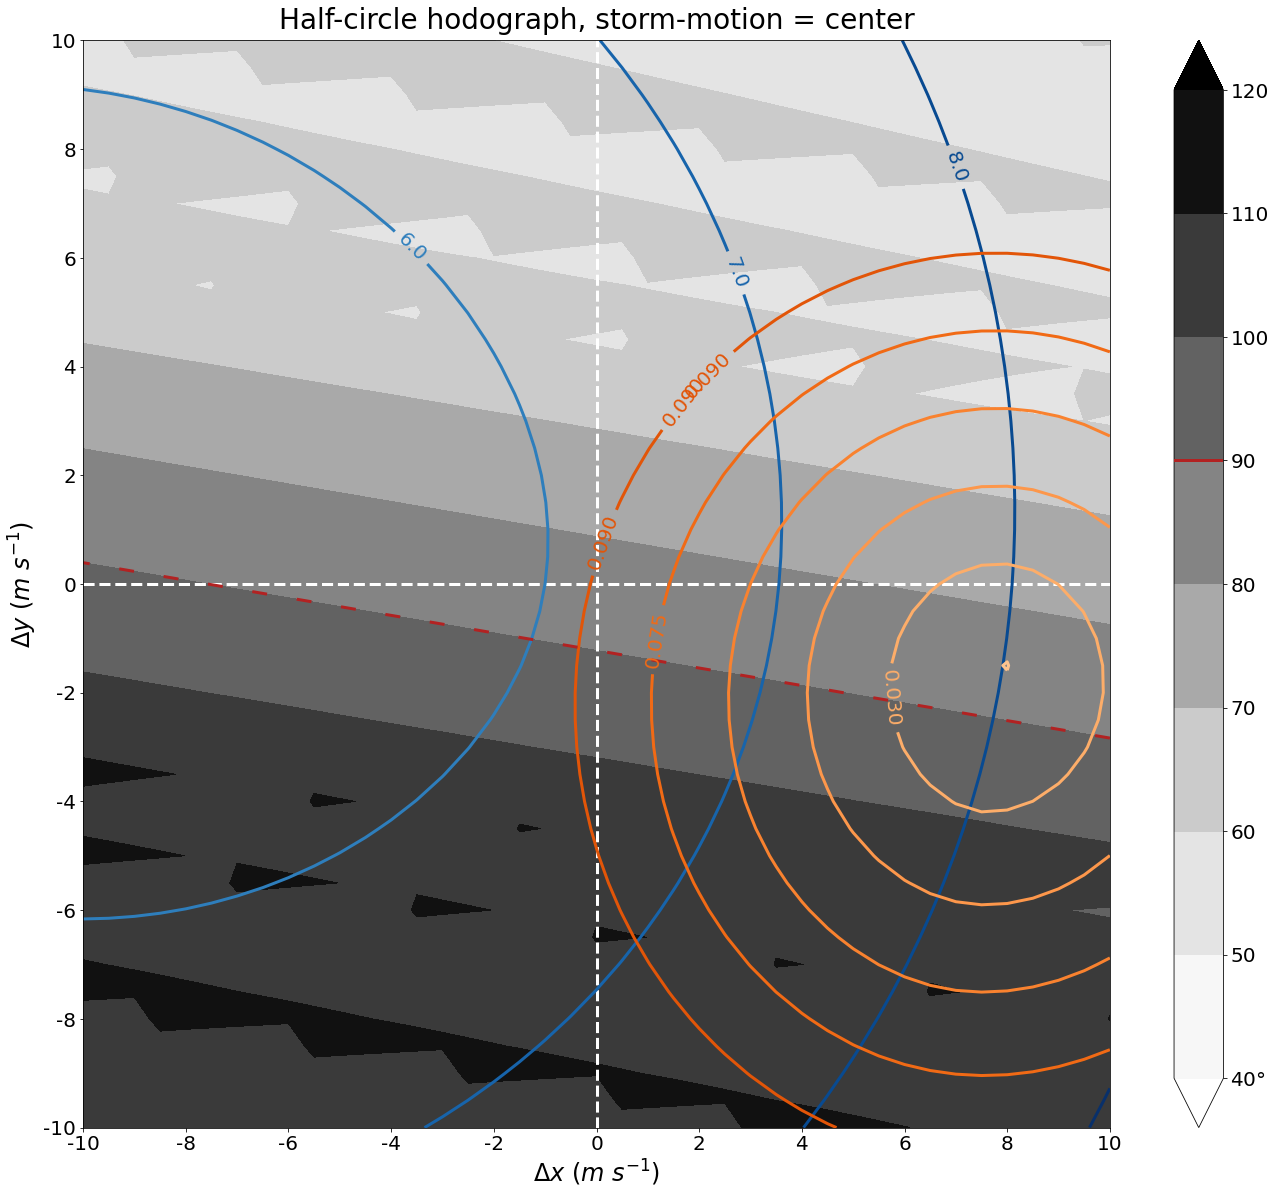

<Figure size 1656x1440 with 0 Axes>

In [273]:
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

fig.patch.set_facecolor('white') 

print(np.max(angle_avg))
print(np.min(angle_avg))
print(np.max(srwind_mag_avg))
print(np.min(srwind_mag_avg))
print(np.max(hvort_mag_avg))
print(np.min(hvort_mag_avg))

levels_srwind = np.arange(6,10,1)
levels_hvort = np.arange(0.015,0.105,0.015)
levels_angle = np.arange(40,130,10)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='white',lw=3)
plt.vlines(0,left,right,ls='--',colors='white',lw=3)

# --- plot contours and fill ---
cax = plt.contourf(allx,ally,angle_avg.T,cmap='Greys',levels=levels_angle,alpha=1.0,extend='both')
cbar = fig.colorbar(cax,ticks=np.arange(40,130,10))
cbarlabels = [r'40$\degree$','50','60','70','80','90','100','110','120']
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)
cbar.ax.plot([40,120],[90]*2,color='firebrick',linewidth=3,zorder=20,linestyle='-')

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap,0.7,1.0)
cs1 = plt.contour(allx,ally,srwind_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_srwind)
locs = [(-3.8,6),(3.5,6),(8,8)]
ax.clabel(cs1, inline=1, fontsize=20, fmt='%1.1f', manual=locs)

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap,0.3,0.7)
cs2 = plt.contour(allx,ally,hvort_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_hvort)
locs = [(6.5,-2),(1,-1),(2,4),(-5,2.5),(-4.5,8.2)]
ax.clabel(cs2, inline=1, fontsize=20, fmt='%1.3f', manual=locs)

# --- highlight 90 degree contour ---
plt.contour(allx,ally,angle_avg.T,levels=[90],colors='firebrick',linewidths=3,linestyles=[(0,(5,10))])

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

plt.title(r'Half-circle hodograph, storm-motion = center',fontsize=28,y=1.005)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/extras/srhcomps_100',dpi=300)
# plt.show()
# plt.clf()






In [115]:
#-----------------------------------------------------------------------
# Now loop through and calculate mean horizontal shear magnitude, 
# storm-relative wind magnitude, and the angle between the two in the
# friction layer (0–250 m AGL) for all delta x/y.
#
# This section is for an assumed storm motion = Bunkers right.
#-----------------------------------------------------------------------
hvort_x_avg = np.ones((num_x,num_y))*np.nan
hvort_y_avg = np.ones((num_x,num_y))*np.nan
hvort_mag_avg = np.ones((num_x,num_y))*np.nan

srwind_x_avg = np.ones((num_x,num_y))*np.nan
srwind_y_avg = np.ones((num_x,num_y))*np.nan
srwind_mag_avg = np.ones((num_x,num_y))*np.nan

angle_avg = np.ones((num_x,num_y))*np.nan


#-----------------------------------------------------------------------
# Copy a lot of the code from the cell above to recreate u/v_circle and
# u2/v2.
#-----------------------------------------------------------------------
for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        # --- u2 and v2 will become the hodo with friction ---
        u2 = np.copy(u) + allx[i]
        v2 = np.copy(v) + ally[j]
        
        # --- u_circle and v_circle will remain the full half-circle ---
        u_circle = np.copy(u) + allx[i]
        v_circle = np.copy(v) + ally[j]
                
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate the linear component.
            #-----------------------------------------------------------------------
            u_l = 0 + (z/fric_height)*u2[fric_index]
            v_l = 0 + (z/fric_height)*v2[fric_index]
            
            if allx[i] == 0 and ally[j] == 0:
                u_l2[count] = u_l
                v_l2[count] = v_l

            #-----------------------------------------------------------------------
            # Calculate the half-circle component.
            #-----------------------------------------------------------------------
            u_c = u2[count]
            v_c = v2[count]

            #-----------------------------------------------------------------------
            # Calculate the weight (of the linear part).
            #-----------------------------------------------------------------------
            weight[count] = (np.exp((fric_height-z)/fric_height)-1)/(np.exp(1)-1) * (1-(z/fric_height))

            #-----------------------------------------------------------------------
            # Combine the two using weights to get the final curvy components.
            #-----------------------------------------------------------------------
            u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
            v2[count] = v_l * weight[count] + v_c * (1 - weight[count])

            count += 1
            
        #-----------------------------------------------------------------------
        # Now that we have the full wind profile (u2,v2), calculate Bunkers-
        # right motion.
        #-----------------------------------------------------------------------
        p_blah_units = p_blah * units.millibar
        u2_units = u2 * units.meter / units.second
        v2_units = v2 * units.meter / units.second
        z_blah_units = z_blah * units.meter
        
        sm = calc.bunkers_storm_motion(p_blah_units,u2_units,v2_units,z_blah_units)
        u_sm[i,j] = sm[0][0].magnitude
        v_sm[i,j] = sm[0][1].magnitude
        
        # --- repeat for the profile without friction ---
        u_circle_units = u_circle * units.meter / units.second
        v_circle_units = v_circle * units.meter / units.second
        
        sm_circle = calc.bunkers_storm_motion(p_blah_units,u_circle_units,v_circle_units,z_blah_units)
        u_sm_circle[i,j] = sm_circle[0][0].magnitude
        v_sm_circle[i,j] = sm_circle[0][1].magnitude
        
        #-----------------------------------------------------------------------
        # Also calculate the mean wind.
        #-----------------------------------------------------------------------
        u_mw[i,j] = np.mean(u2[:600])
        v_mw[i,j] = np.mean(v2[:600])
        
        # --- repeat for the profile without friction ---
        u_mw_circle[i,j] = np.mean(u_circle[:600])
        v_mw_circle[i,j] = np.mean(v_circle[:600])
        
        #-----------------------------------------------------------------------
        # Now calculate mean horizontal vorticity and storm-relative wind
        # magnitudes in the friction layer.
        #-----------------------------------------------------------------------
        hvort_x = np.ones((int(fric_height/10)))*np.nan
        hvort_y = np.ones((int(fric_height/10)))*np.nan
        hvort_mag = np.ones((int(fric_height/10)))*np.nan
        
        srwind_x = np.ones((int(fric_height/10)))*np.nan
        srwind_y = np.ones((int(fric_height/10)))*np.nan
        srwind_mag = np.ones((int(fric_height/10)))*np.nan
        
        angle = np.ones((int(fric_height/10)))*np.nan
        
        count = 1
        for z in np.arange(10,fric_height-10,10):
            # --- HODOGRAPH WITH FRICTION ---
            # --- horizontal vorticity ---
            hvort_x[count] = -(v2[count+1] - v2[count-1])/20.
            hvort_y[count] = (u2[count+1] - u2[count-1])/20.
            
            hvort_mag[count] = ((hvort_x[count])**2 + (hvort_y[count])**2)**(0.5)
            
            # --- storm-relative wind (center) ---
            srwind_x[count] = u2[count] - u_sm[i,j]
            srwind_y[count] = v2[count] - v_sm[i,j]
            
            srwind_mag[count] = ((srwind_x[count])**2 + (srwind_y[count])**2)**(0.5)
            
            # --- angle between the two ---
            dot = hvort_x[count] * srwind_x[count] + hvort_y[count] * srwind_y[count]
            
            angle[count] = np.degrees(np.arccos(dot))
            
            count += 1
            
        hvort_x_avg[i,j] = np.nanmean(hvort_x)
        hvort_y_avg[i,j] = np.nanmean(hvort_y)
        hvort_mag_avg[i,j] = np.nanmean(hvort_mag)
        
        srwind_x_avg[i,j] = np.nanmean(srwind_x)
        srwind_y_avg[i,j] = np.nanmean(srwind_y)
        srwind_mag_avg[i,j] = np.nanmean(srwind_mag)
        
        angle_avg[i,j] = np.nanmean(angle)
        
    print(i,'/',num_x-1)
                    
            





<ipython-input-115-2269d13ab28c>:133: RuntimeWarning: invalid value encountered in arccos
  angle[count] = np.degrees(np.arccos(dot))


0 / 40
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40


104.27375186534199
56.82499779107918
13.436349394445763
9.040359469880975
0.0940227874379131
0.013535406607334955


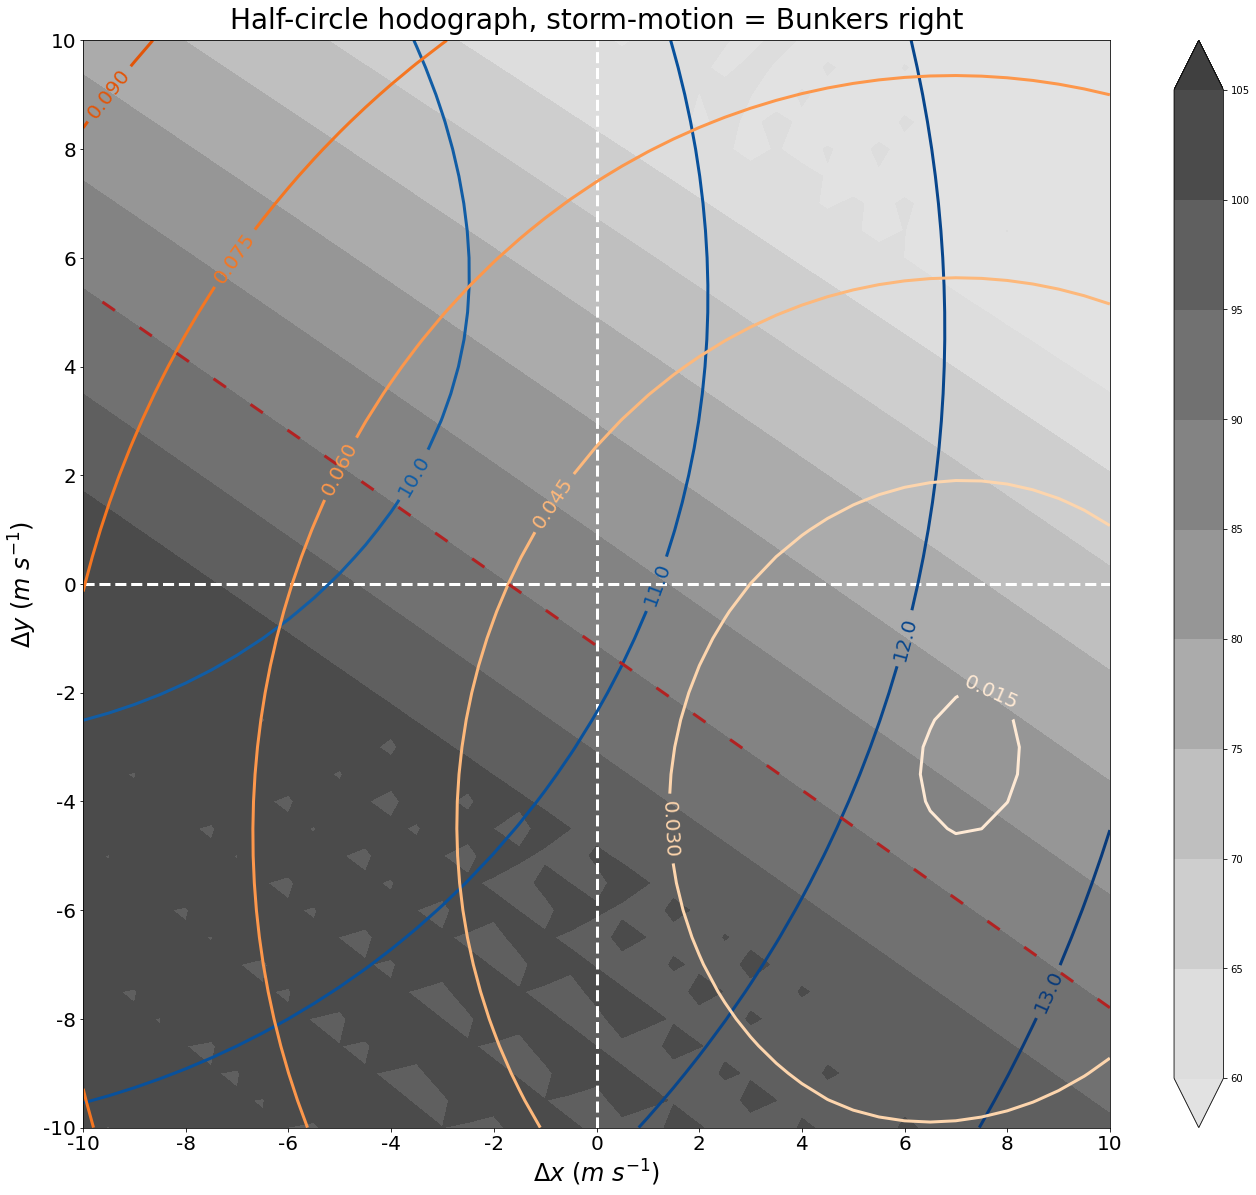

<Figure size 1656x1440 with 0 Axes>

In [130]:
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

fig.patch.set_facecolor('white') 

print(np.max(angle_avg))
print(np.min(angle_avg))
print(np.max(srwind_mag_avg))
print(np.min(srwind_mag_avg))
print(np.max(hvort_mag_avg))
print(np.min(hvort_mag_avg))

levels_srwind = np.arange(7,15,1)
levels_hvort = np.arange(0.015,0.105,0.015)
levels_angle = np.arange(40,130,10)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='white',lw=3)
plt.vlines(0,left,right,ls='--',colors='white',lw=3)

# --- plot contours and fill ---
# cax = plt.contourf(allx,ally,angle_avg.T,cmap='Greys',levels=levels_angle,alpha=1.0,extend='both')
cmap = plt.get_cmap('Greys')
new_cmap = truncate_colormap(cmap,0.2,0.8)
cax = plt.contourf(allx,ally,angle_avg.T,cmap=new_cmap,levels=np.arange(60,110,5),extend='both')
# cbar = fig.colorbar(cax,ticks=np.arange(40,130,10))
cbar = fig.colorbar(cax)
# cbarlabels = [r'40$\degree$','50','60','70','80','90','100','110','120']
# cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap,0.7,1.0)
cs1 = plt.contour(allx,ally,srwind_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_srwind)
# locs = [(-1,-2),(-4,-1.7),(-8,-1),(-8.5,3.5),(-9,7)]
ax.clabel(cs1, inline=1, fontsize=20, fmt='%1.1f')

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap,0.1,0.7)
cs2 = plt.contour(allx,ally,hvort_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_hvort)
# locs = [(-4.7,9),(-0.8,1),(1.3,-2),(5,-4),(8.5,-5.5)]
ax.clabel(cs2, inline=1, fontsize=20, fmt='%1.3f')

# --- highlight 90 degree contour ---
plt.contour(allx,ally,angle_avg.T,levels=[90],colors='firebrick',linewidths=3,linestyles=[(0,(5,10))])

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

plt.title(r'Half-circle hodograph, storm-motion = Bunkers right',fontsize=28,y=1.005)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/PostDoc/Research/GRwindFrictionSRH/plots/halfcircle_srhcomps_bunkers',dpi=300)
# plt.show()
# plt.clf()






In [247]:
#-----------------------------------------------------------------------
# Now loop through and calculate mean horizontal shear magnitude, 
# storm-relative wind magnitude, and the angle between the two in the
# friction layer (0–250 m AGL) for all delta x/y.
#
# This section is for an assumed storm motion = mean wind.
#-----------------------------------------------------------------------
hvort_x_avg = np.ones((num_x,num_y))*np.nan
hvort_y_avg = np.ones((num_x,num_y))*np.nan
hvort_mag_avg = np.ones((num_x,num_y))*np.nan

srwind_x_avg = np.ones((num_x,num_y))*np.nan
srwind_y_avg = np.ones((num_x,num_y))*np.nan
srwind_mag_avg = np.ones((num_x,num_y))*np.nan

angle_avg = np.ones((num_x,num_y))*np.nan


#-----------------------------------------------------------------------
# Copy a lot of the code from the cell above to recreate u/v_circle and
# u2/v2.
#-----------------------------------------------------------------------
for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        # --- u2 and v2 will become the hodo with friction ---
        u2 = np.copy(u) + allx[i]
        v2 = np.copy(v) + ally[j]
        
        # --- u_circle and v_circle will remain the full half-circle ---
        u_circle = np.copy(u) + allx[i]
        v_circle = np.copy(v) + ally[j]
                
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate the linear component.
            #-----------------------------------------------------------------------
            u_l = 0 + (z/fric_height)*u2[fric_index]
            v_l = 0 + (z/fric_height)*v2[fric_index]
            
            if allx[i] == 0 and ally[j] == 0:
                u_l2[count] = u_l
                v_l2[count] = v_l

            #-----------------------------------------------------------------------
            # Calculate the half-circle component.
            #-----------------------------------------------------------------------
            u_c = u2[count]
            v_c = v2[count]

            #-----------------------------------------------------------------------
            # Calculate the weight (of the linear part).
            #-----------------------------------------------------------------------
            z0 = 0. # (m)
            weight[count] = 1 - ((z - z0)/fric_height)

            #-----------------------------------------------------------------------
            # Combine the two using weights to get the final curvy components.
            #-----------------------------------------------------------------------
            u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
            v2[count] = v_l * weight[count] + v_c * (1 - weight[count])

            count += 1
            
        #-----------------------------------------------------------------------
        # Now that we have the full wind profile (u2,v2), calculate Bunkers-
        # right motion.
        #-----------------------------------------------------------------------
        p_blah_units = p_blah * units.millibar
        u2_units = u2 * units.meter / units.second
        v2_units = v2 * units.meter / units.second
        z_blah_units = z_blah * units.meter
        
        sm = calc.bunkers_storm_motion(p_blah_units,u2_units,v2_units,z_blah_units)
        u_sm[i,j] = sm[0][0].magnitude
        v_sm[i,j] = sm[0][1].magnitude
        
        # --- repeat for the profile without friction ---
        u_circle_units = u_circle * units.meter / units.second
        v_circle_units = v_circle * units.meter / units.second
        
        sm_circle = calc.bunkers_storm_motion(p_blah_units,u_circle_units,v_circle_units,z_blah_units)
        u_sm_circle[i,j] = sm_circle[0][0].magnitude
        v_sm_circle[i,j] = sm_circle[0][1].magnitude
        
        #-----------------------------------------------------------------------
        # Also calculate the mean wind.
        #-----------------------------------------------------------------------
        u_mw[i,j] = np.mean(u2[:600])
        v_mw[i,j] = np.mean(v2[:600])
                
        # --- repeat for the profile without friction ---
        u_mw_circle[i,j] = np.mean(u_circle[:600])
        v_mw_circle[i,j] = np.mean(v_circle[:600])
        
        #-----------------------------------------------------------------------
        # Now calculate mean horizontal vorticity and storm-relative wind
        # magnitudes in the friction layer.
        #-----------------------------------------------------------------------
        hvort_x = np.ones((int(fric_height/10)))*np.nan
        hvort_y = np.ones((int(fric_height/10)))*np.nan
        hvort_mag = np.ones((int(fric_height/10)))*np.nan
        
        srwind_x = np.ones((int(fric_height/10)))*np.nan
        srwind_y = np.ones((int(fric_height/10)))*np.nan
        srwind_mag = np.ones((int(fric_height/10)))*np.nan
        
        angle = np.ones((int(fric_height/10)))*np.nan
        
        count = 1
        for z in np.arange(10,fric_height-10,10):
            # --- HODOGRAPH WITH FRICTION ---
            # --- horizontal vorticity ---
            hvort_x[count] = -(v2[count+1] - v2[count-1])/20.
            hvort_y[count] = (u2[count+1] - u2[count-1])/20.
            
            hvort_mag[count] = ((hvort_x[count])**2 + (hvort_y[count])**2)**(0.5)
            
            # --- storm-relative wind (center) ---
            srwind_x[count] = u2[count] - u_mw[i,j]
            srwind_y[count] = v2[count] - v_mw[i,j]
            
            srwind_mag[count] = ((srwind_x[count])**2 + (srwind_y[count])**2)**(0.5)
            
            # --- angle between the two ---
            dot = hvort_x[count] * srwind_x[count] + hvort_y[count] * srwind_y[count]
            
            angle[count] = np.degrees(np.arccos(dot))
            
            count += 1
            
        hvort_x_avg[i,j] = np.nanmean(hvort_x)
        hvort_y_avg[i,j] = np.nanmean(hvort_y)
        hvort_mag_avg[i,j] = np.nanmean(hvort_mag)
        
        srwind_x_avg[i,j] = np.nanmean(srwind_x)
        srwind_y_avg[i,j] = np.nanmean(srwind_y)
        srwind_mag_avg[i,j] = np.nanmean(srwind_mag)
        
        angle_avg[i,j] = np.nanmean(angle)
        
    print(i,'/',num_x-1)
                    
            





<ipython-input-247-681aed9a2d4d>:131: RuntimeWarning: invalid value encountered in arccos
  angle[count] = np.degrees(np.arccos(dot))


0 / 40
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40


109.45512903612097
45.769755509402906
14.360768790807095
7.375931007145062
0.09313248584646795
0.008161544876275243


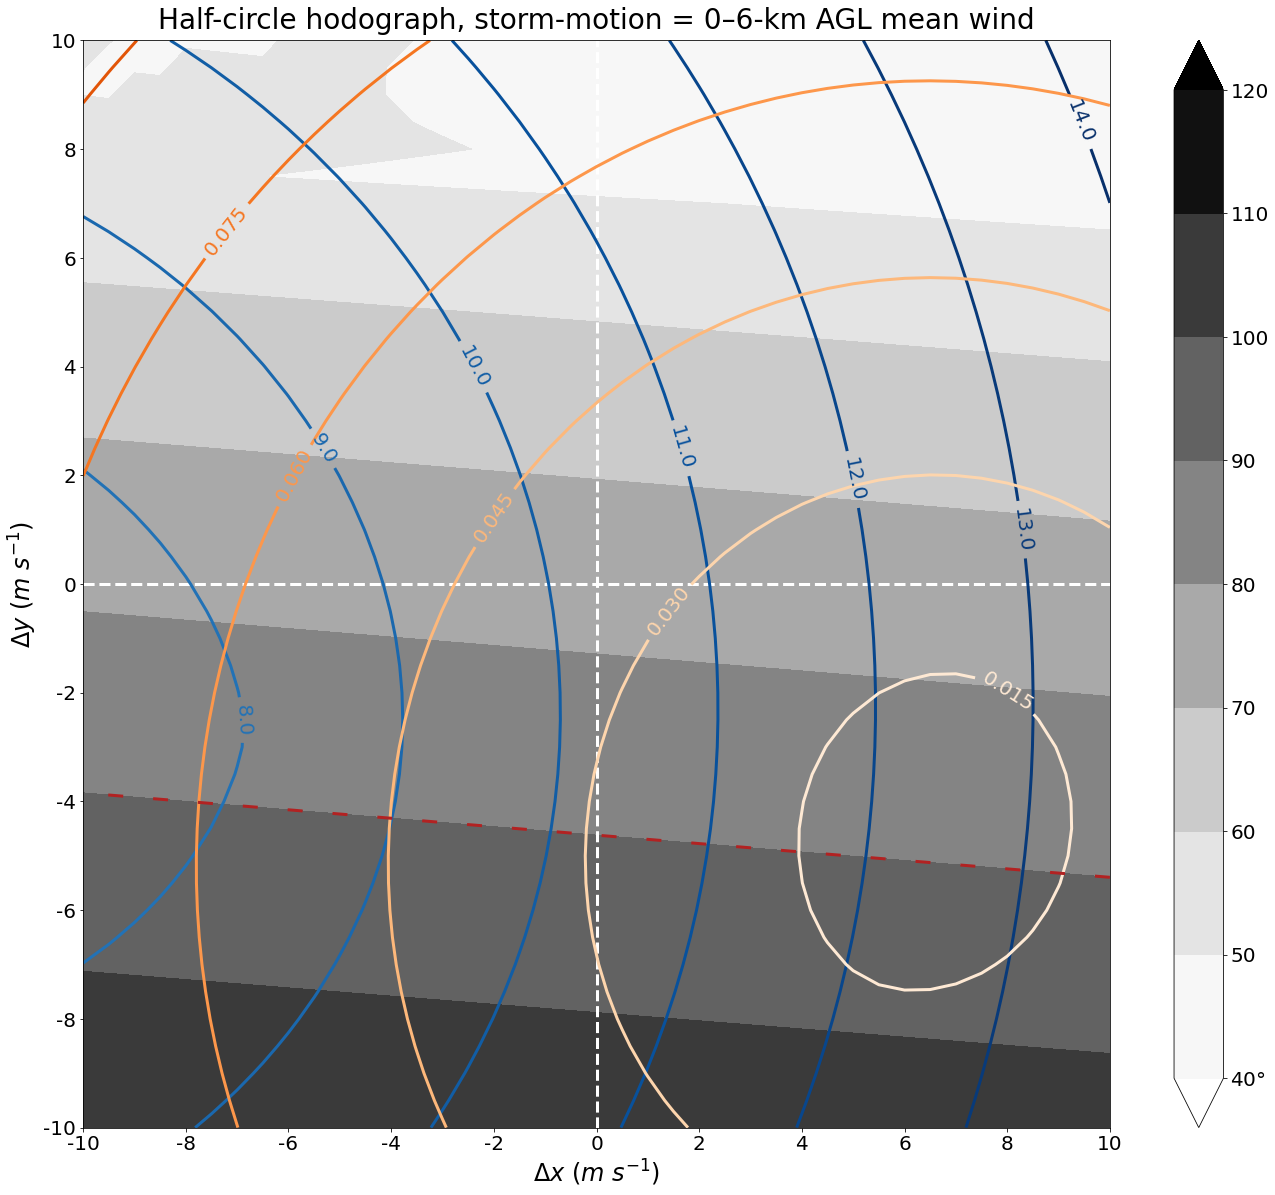

In [248]:
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

fig.patch.set_facecolor('white') 

print(np.max(angle_avg))
print(np.min(angle_avg))
print(np.max(srwind_mag_avg))
print(np.min(srwind_mag_avg))
print(np.max(hvort_mag_avg))
print(np.min(hvort_mag_avg))

levels_srwind = np.arange(7,15,1)
levels_hvort = np.arange(0.015,0.105,0.015)
levels_angle = np.arange(40,130,10)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='white',lw=3)
plt.vlines(0,left,right,ls='--',colors='white',lw=3)

# --- plot contours and fill ---
cax = plt.contourf(allx,ally,angle_avg.T,cmap='Greys',levels=levels_angle,alpha=1.0,extend='both')
cbar = fig.colorbar(cax,ticks=np.arange(40,130,10))
cbarlabels = [r'40$\degree$','50','60','70','80','90','100','110','120']
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap,0.7,1.0)
cs1 = plt.contour(allx,ally,srwind_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_srwind)
# locs = [(-1,-2),(-4,-1.7),(-8,-1),(-8.5,3.5),(-9,7)]
ax.clabel(cs1, inline=1, fontsize=20, fmt='%1.1f')

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap,0.1,0.7)
cs2 = plt.contour(allx,ally,hvort_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_hvort)
# locs = [(-4.7,9),(-0.8,1),(1.3,-2),(5,-4),(8.5,-5.5)]
ax.clabel(cs2, inline=1, fontsize=20, fmt='%1.3f')

# --- highlight 90 degree contour ---
plt.contour(allx,ally,angle_avg.T,levels=[90],colors='firebrick',linewidths=3,linestyles=[(0,(5,10))])

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

plt.title(r'Half-circle hodograph, storm-motion = 0–6-km AGL mean wind',fontsize=28,y=1.005)

plt.show()






In [249]:
##########################################################################
# Now back to the updated cells with the straight-line hodograph.
##########################################################################

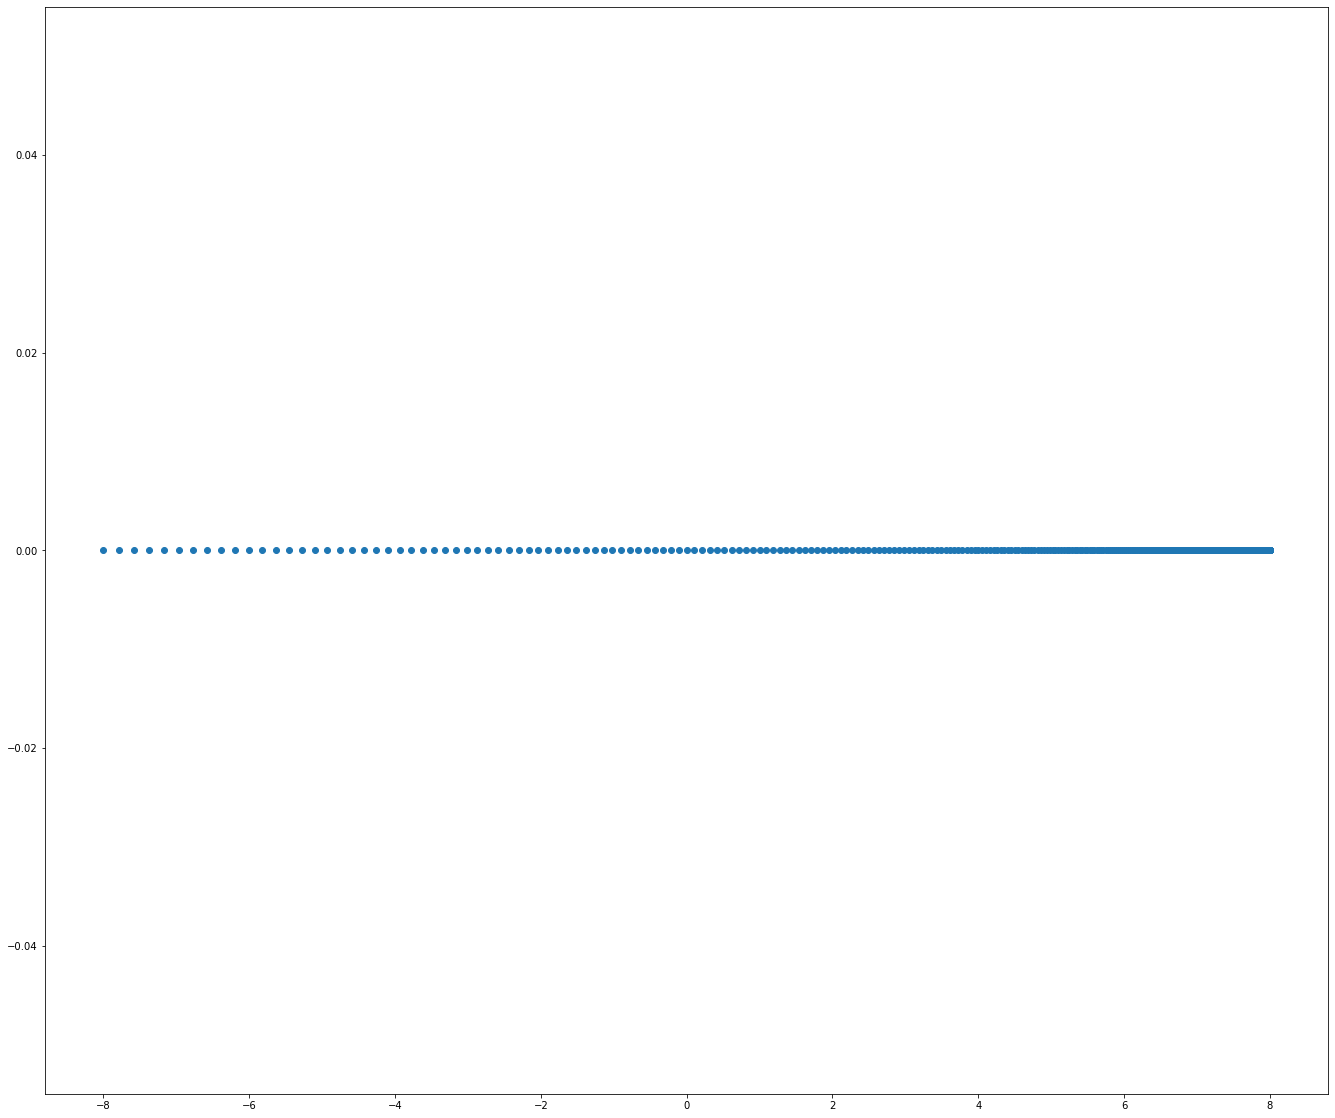

In [188]:
#-----------------------------------------------------------------------
# Now create a straight hodograph and repeat the process.
#-----------------------------------------------------------------------
#-----------------------------------------------------------------------
# Create hodographs per Markowski and Richardson (2014). First, define
# heights and sounding parameters.
#-----------------------------------------------------------------------
heights = np.arange(0,18010,10)

A = 16 # hodograph length (m/s)
H = 6000 # vertical scale (m)
m = 8 # compression scale (unitless)
z0 = 750 # height of maximum v (m)

num_heights = np.size(heights)

us = np.ones((num_heights))*np.nan
vs = np.ones((num_heights))*np.nan

#-----------------------------------------------------------------------
# Create the base hodograph (without friction).
#-----------------------------------------------------------------------
count = 0
for z in np.arange(0,18010,10):
    #-----------------------------------------------------------------------
    # Calculate v from z.
    #-----------------------------------------------------------------------
    vs[count] = 0
    
    #-----------------------------------------------------------------------
    # Calculate u from v and z.
    #-----------------------------------------------------------------------
    zdiff = z - z0
        
    if zdiff < 0:
        sgn = 1
    elif zdiff == 0:
        sgn = 0
    elif zdiff > 0:
        sgn = -1
            
    us[count] = (np.exp(1) - np.exp(1-m*z/(H))) * A/np.exp(1) - 8
    
    count += 1
        
plt.scatter(us,vs)
plt.show()



In [189]:
#-----------------------------------------------------------------------
# Loop through hodograph centers and calculate SRH at each one.
#-----------------------------------------------------------------------
left = -10
right = 10
bottom = -10
top = 10
step = 0.5

fric_height = 250
fric_index = int(fric_height/10)

num_heights = np.size(np.arange(0,fric_height,10))
weight = np.ones((num_heights))*np.nan

allx = np.arange(left,right+step,step)
ally = np.arange(bottom,top+step,step)

num_x = np.size(allx)
num_y = np.size(ally)

srh_all = np.ones((num_x,num_y))*np.nan
u_sm = np.ones((num_x,num_y))*np.nan

for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        u2 = np.copy(us) + allx[i]
        v2 = np.copy(vs) + ally[j]
        
        #-----------------------------------------------------------------------
        #-----------------------------------------------------------------------
        # Calculate the circular hodograph from 0–fric_height m AGL in order
        # to parameterize friction below.
        #-----------------------------------------------------------------------
        A = abs(v2[fric_index]) # hodograph radius (m/s)
        H = 6000 # vertical scale (m)
        m = 24 # compression scale (unitless)
        z0 = fric_height # height of maximum v (m)

        heights_circ = np.arange(0,fric_height,10)
        num_heights = np.size(heights_circ)

        ucirc = np.ones((num_heights))*np.nan
        vcirc = np.ones((num_heights))*np.nan

        #-----------------------------------------------------------------------
        # Create the circular part.
        #-----------------------------------------------------------------------
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate v from z.
            #-----------------------------------------------------------------------
            if v2[fric_index] < 0:
                sgn = -1
            elif v2[fric_index] > 0:
                sgn = 1
                
            vcirc[count] = sgn*A*m*z/H*np.exp(1-(m*z/H))

            #-----------------------------------------------------------------------
            # Calculate u from v and z.
            #-----------------------------------------------------------------------
            zdiff = z - z0

            if zdiff < 0:
                sgn = -1
            elif zdiff == 0:
                sgn = 0
            elif zdiff > 0:
                sgn = 1

            ucirc[count] = sgn*(A**2 - vcirc[count]**2)**(0.5) + allx[i]
            
            count += 1
                    
        #-----------------------------------------------------------------------
        # Finally, tweak the circular part so that it aligns with the linear
        # part.
        #-----------------------------------------------------------------------
        udiff = ucirc[count-1] - u2[fric_index]
        ucirc = ucirc - udiff   
        vcirc[count-1] = v2[fric_index]
        #-----------------------------------------------------------------------
        #-----------------------------------------------------------------------        
        
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate the linear component due to friction.
            #-----------------------------------------------------------------------
            u_l = 0 + (z/fric_height)*u2[fric_index]
            v_l = 0 + (z/fric_height)*v2[fric_index]

            #-----------------------------------------------------------------------
            # Calculate the half-circle component.
            #-----------------------------------------------------------------------
            u_c = ucirc[count]
            v_c = vcirc[count]
            
            #-----------------------------------------------------------------------
            # Calculate the weight (of the linear part).
            #-----------------------------------------------------------------------
            weight[count] = (np.exp((fric_height-z)/fric_height)-1)/(np.exp(1)-1) * (1-(z/fric_height))

            #-----------------------------------------------------------------------
            # Combine the two using weights to get the final curvy components.
            #-----------------------------------------------------------------------
            u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
            v2[count] = v_l * weight[count] + v_c * (1 - weight[count])

            count += 1
            
        #-----------------------------------------------------------------------
        # Now that we have the full wind profile (u2,v2), calculate Bunkers-
        # right motion.
        #-----------------------------------------------------------------------
        p_blah_units = p_blah * units.millibar
        u2_units = u2 * units.meter / units.second
        v2_units = v2 * units.meter / units.second
        z_blah_units = z_blah * units.meter
        
        sm = calc.bunkers_storm_motion(p_blah_units,u2_units,v2_units,z_blah_units)
        u_sm[i,j] = sm[0][0].magnitude
        v_sm[i,j] = sm[0][1].magnitude
                
        sm_circle = calc.bunkers_storm_motion(p_blah_units,u_circle_units,v_circle_units,z_blah_units)
                        
        if allx[i] == 0 and ally[j] == 5:
            ut1 = np.copy(u2)
            vt1 = np.copy(v2)
            
            u_sm1 = u_sm[i,j]
            v_sm1 = v_sm[i,j]
            
        if allx[i] == -2 and ally[j] == -3:
            ut2 = np.copy(u2)
            vt2 = np.copy(v2)
            
            u_sm2 = u_sm[i,j]
            v_sm2 = v_sm[i,j]
            
        if allx[i] == 4 and ally[j] == 3:
            ut3 = np.copy(u2)
            vt3 = np.copy(v2)
                                       
        # --- calculate SRH ---
        srh_all[i,j] = calc_srh(u2,v2,heights,u_sm[i,j],v_sm[i,j],0,250) # storm motion = Bunkers
#         srh_all[i,j] = calc_srh(u2,v2,heights,u2[300],v2[300],0,250) # storm motion = 3 km AGL wind
#         srh_all[i,j] = calc_srh(u2,v2,heights,allx[i],ally[j],0,250) # this storm motion is aphysical
                
#         print(allx[i],ally[j],srh_all[i,j])

    print(i,'/',num_x-1)
                                
print('Maximum SRH: ',np.max(srh_all))
print('Minimum SRH: ',np.min(srh_all))
            

0 / 40
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40
Maximum SRH:  193.03789167308037
Minimum SRH:  -266.262289467243


In [197]:
print(srh_all[21,31])

58.24949709058698


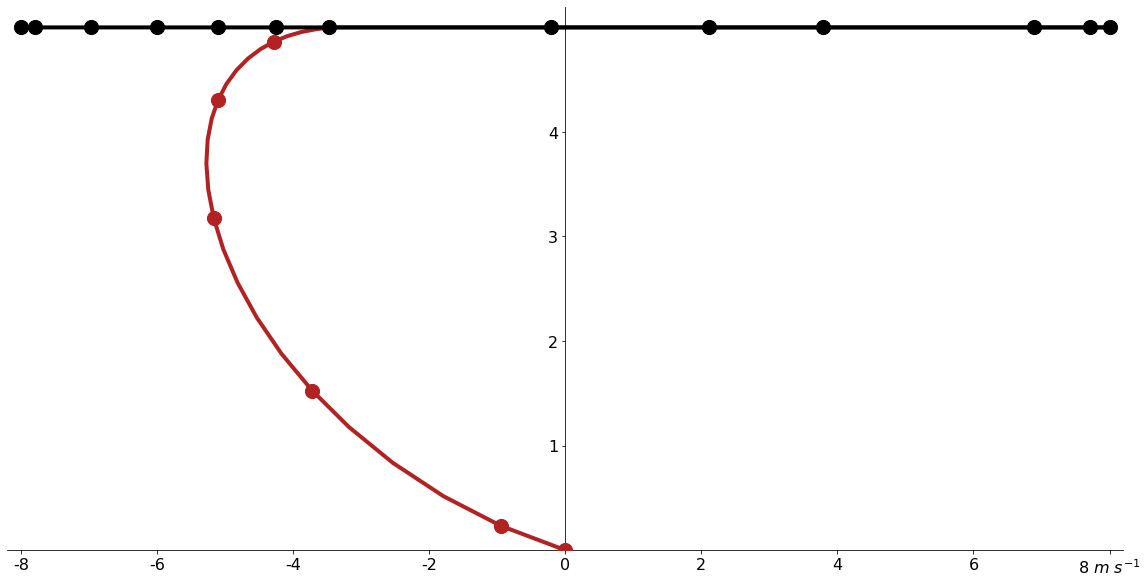

<Figure size 1440x720 with 0 Axes>

In [190]:
#-----------------------------------------------------------------------
# Make a plot of the straight hodographs before plotting SRH.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 20,10

fig,ax = plt.subplots()

#-----------------------------------------------------------------------
# Plot the "curvy" one, which only differs below z_fric.
#-----------------------------------------------------------------------
ax.plot(ut1,vt1,c='firebrick',lw=4)

# --- add a point at 0 m AGL ---
height_dots = np.array([0.,10.,50.,100.,150.,200.]) # m
height_inds = height_dots/10.

for i in np.arange(0,len(height_inds)):
    ax.scatter(ut1[int(height_inds[i])],vt1[int(height_inds[i])],s=200,c='firebrick',zorder=10)

#-----------------------------------------------------------------------
# And the straight line.
#-----------------------------------------------------------------------
ax.plot(us,vs+5,c='k',lw=4)

# --- make borders disappear ---
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position('center')
ax.spines['right'].set_visible(False)

# --- add desired heights ---
height_dots = np.array([0.,10.,50.,100.,150.,200.,250.,500.,750.,1000.,2000.,3000.,18000.]) # m
height_inds = height_dots/10.

for i in np.arange(0,len(height_inds)):
    ax.scatter(us[int(height_inds[i])],vs[int(height_inds[i])]+5,s=200,c='k',zorder=10)
    
# --- tweak axes ---
plt.xlim([-8.2,8.2])
plt.ylim([-0,5.2])
plt.xticks(np.arange(-8,10,2),labels=['-8','-6','-4','-2','0','2','4','6',r'8 $m$ $s^{-1}$'],fontsize=16)
plt.yticks(np.arange(1,5,1),fontsize=16)

# --- save ---
# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/fig2',dpi=300)
# plt.show()
# plt.clf()

In [191]:
#-----------------------------------------------------------------------
# Calculate SRH.
#-----------------------------------------------------------------------
srh = calc_srh(us,vs+5,heights,0,0,0,250)
srhf = calc_srh(ut1,vt1,heights,0,0,0,250)

print('Storm motion at origin without friction: SRH = ',srh)
print('Storm motion at origin with friction: SRH = ',srhf)


Storm motion at origin without friction: SRH =  22.5273152771298
Storm motion at origin with friction: SRH =  22.893617004105128


6.371761328721571 -2.5616509532565974
-10 10 -10 10


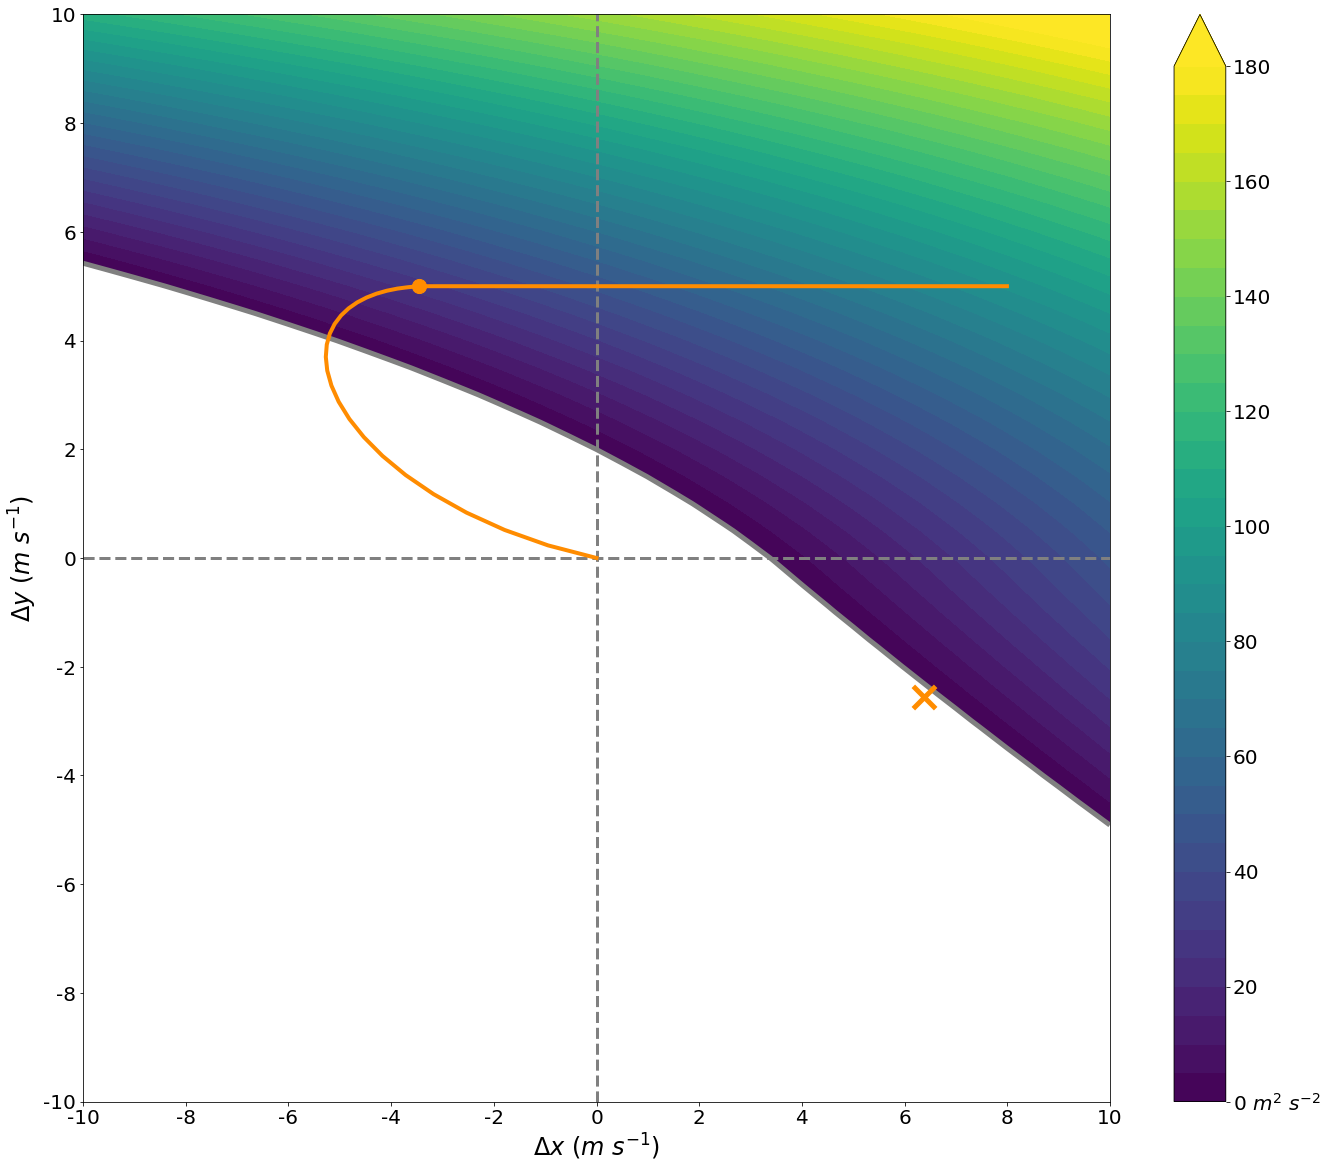

SRH at delta x/y = (0,5):  46.54242802644538


<Figure size 1656x1440 with 0 Axes>

In [193]:
#-----------------------------------------------------------------------
# Contour SRH.
#-----------------------------------------------------------------------
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

levels = np.arange(0,185,5)
cax = plt.contourf(allx,ally,srh_all.T,levels=levels,extend='max')

# --- customize colorbar ---
cbar = fig.colorbar(cax,ticks=np.arange(0,200,20))
cbarlabels = [r'0 $m^{2}$ $s^{-2}$','20','40','60','80','100','120','140','160','180']
# cbar.ax.set_yticks(np.arange(0,250,50))
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)

# plt.plot(ucirc,vcirc,c='white',lw=3,ls='--')

# --- plot curved friction hodograph at origin ---
plt.plot(ut1[:600],vt1[:600],c='darkorange',lw=4,zorder=11) # hodograph up to the height of the storm motion
plt.scatter(ut1[25],vt1[25],c='darkorange',s=200) # top of friction layer
print(u_sm1,v_sm1)
plt.scatter(u_sm1,v_sm1,c='darkorange',marker='x',linewidth=5,s=500,zorder=5) # storm motion 
# plt.scatter(np.mean(ut1),np.mean(vt1),c='white',s=300) # plot mean wind for this case

#--- plot a case with more SRH ---
# plt.plot(ut2[:600],vt2[:600],c='k',lw=4,ls=(0,(3,3))) # hodograph
# plt.scatter(ut2[25],vt2[25],c='k',s=200,zorder=5) # top of friction layer
# plt.scatter(u_sm2,v_sm2,c='k',s=500,zorder=5,marker='x',linewidth=2) # storm motion

# print(u_sm2,v_sm2)

# # --- plot a case with less SRH ---
# plt.plot(ut3[:600],vt3[:600],c='darkorange',lw=4,ls=(0,(3,3)))
# plt.scatter(ut3[25],vt3[25],c='darkorange',s=200,zorder=5)
# # plt.scatter(5,7,c='black',s=500,zorder=5,marker='x',linewidth=5)
# plt.scatter(np.mean(ut3[:600]),np.mean(vt3[:600]),c='darkorange',s=800,zorder=5,marker='x',linewidth=2)


# --- highlight 250 m, origin, and "center" of hodograph ---
# plt.scatter(u_curvy[25],v_curvy[25],c='white',s=200,zorder=5)
# plt.scatter(0,0,c='white',s=200,zorder=5) 
# plt.scatter(-1,4,c='white',s=200,zorder=5)

# --- highlight 0 isopleth ---
# plt.contour(allx,ally,srh_all.T,levels=[0],colors='gray',linewidths=5)

print(bottom,top,left,right)
# --- plot 0 axes ---
plt.hlines(0,bottom,top,ls='--',colors='gray',lw=3)
plt.vlines(0,left,right,ls='--',colors='gray',lw=3)

# --- axis limits ---
plt.xlim([-10,10])
plt.ylim([-10,10])

# --- highlight 0 isopleth ---
plt.contour(allx,ally,srh_all.T,levels=[0],colors='gray',linewidths=5)

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = np.arange(-10,12,2)

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

# --- title ---
# plt.title('0–250-m SRH',fontsize=24)

# --- save ---
# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/fig5',dpi=300)
# plt.show()
# plt.clf()

print('SRH at delta x/y = (0,5): ',srh_all[20,30])




In [200]:
#-----------------------------------------------------------------------
# Now loop through and calculate mean horizontal shear magnitude, 
# storm-relative wind magnitude, and the angle between the two in the
# friction layer (0–250 m AGL) for all delta x/y.
#
# This section is for an assumed storm motion = Bunkers right.
#-----------------------------------------------------------------------
hvort_x_avg = np.ones((num_x,num_y))*np.nan
hvort_y_avg = np.ones((num_x,num_y))*np.nan
hvort_mag_avg = np.ones((num_x,num_y))*np.nan

srwind_x_avg = np.ones((num_x,num_y))*np.nan
srwind_y_avg = np.ones((num_x,num_y))*np.nan
srwind_mag_avg = np.ones((num_x,num_y))*np.nan

angle_avg = np.ones((num_x,num_y))*np.nan


#-----------------------------------------------------------------------
# Copy a lot of the code from above to recreate u/v_circle and
# u2/v2.
#-----------------------------------------------------------------------
left = -10
right = 10
bottom = -10
top = 10
step = 0.5

fric_height = 250
fric_index = int(fric_height/10)

num_heights = np.size(np.arange(0,fric_height,10))
weight = np.ones((num_heights))*np.nan

allx = np.arange(left,right+step,step)
ally = np.arange(bottom,top+step,step)

num_x = np.size(allx)
num_y = np.size(ally)

srh_all = np.ones((num_x,num_y))*np.nan
u_sm = np.ones((num_x,num_y))*np.nan

for i in np.arange(0,num_x):
    for j in np.arange(0,num_y):
        #-----------------------------------------------------------------------
        # Calculate frictional effect on the hodograph at this spot.
        #-----------------------------------------------------------------------
        u2 = np.copy(us) + allx[i]
        v2 = np.copy(vs) + ally[j]
        
        #-----------------------------------------------------------------------
        #-----------------------------------------------------------------------
        # Calculate the circular hodograph from 0–fric_height m AGL in order
        # to parameterize friction below.
        #-----------------------------------------------------------------------
        A = abs(v2[fric_index]) # hodograph radius (m/s)
        H = 6000 # vertical scale (m)
        m = 24 # compression scale (unitless)
        z0 = fric_height # height of maximum v (m)

        heights_circ = np.arange(0,fric_height,10)
        num_heights = np.size(heights_circ)

        ucirc = np.ones((num_heights))*np.nan
        vcirc = np.ones((num_heights))*np.nan

        #-----------------------------------------------------------------------
        # Create the circular part.
        #-----------------------------------------------------------------------
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate v from z.
            #-----------------------------------------------------------------------
            if v2[fric_index] < 0:
                sgn = -1
            elif v2[fric_index] > 0:
                sgn = 1
                
            vcirc[count] = sgn*A*m*z/H*np.exp(1-(m*z/H))

            #-----------------------------------------------------------------------
            # Calculate u from v and z.
            #-----------------------------------------------------------------------
            zdiff = z - z0

            if zdiff < 0:
                sgn = -1
            elif zdiff == 0:
                sgn = 0
            elif zdiff > 0:
                sgn = 1

            ucirc[count] = sgn*(A**2 - vcirc[count]**2)**(0.5) + allx[i]
            
            count += 1
                    
        #-----------------------------------------------------------------------
        # Finally, tweak the circular part so that it aligns with the linear
        # part.
        #-----------------------------------------------------------------------
        udiff = ucirc[count-1] - u2[fric_index]
        ucirc = ucirc - udiff   
        vcirc[count-1] = v2[fric_index]
        #-----------------------------------------------------------------------
        #-----------------------------------------------------------------------        
        
        count = 0
        for z in np.arange(0,fric_height,10):
            #-----------------------------------------------------------------------
            # Calculate the linear component due to friction.
            #-----------------------------------------------------------------------
            u_l = 0 + (z/fric_height)*u2[fric_index]
            v_l = 0 + (z/fric_height)*v2[fric_index]

            #-----------------------------------------------------------------------
            # Calculate the half-circle component.
            #-----------------------------------------------------------------------
            u_c = ucirc[count]
            v_c = vcirc[count]
            
            #-----------------------------------------------------------------------
            # Calculate the weight (of the linear part).
            #-----------------------------------------------------------------------
            weight[count] = (np.exp((fric_height-z)/fric_height)-1)/(np.exp(1)-1) * (1-(z/fric_height))

            #-----------------------------------------------------------------------
            # Combine the two using weights to get the final curvy components.
            #-----------------------------------------------------------------------
            u2[count] = u_l * weight[count] + u_c * (1 - weight[count])
            v2[count] = v_l * weight[count] + v_c * (1 - weight[count])

            count += 1
            
        #-----------------------------------------------------------------------
        # Now that we have the full wind profile (u2,v2), calculate Bunkers-
        # right motion.
        #-----------------------------------------------------------------------
        p_blah_units = p_blah * units.millibar
        u2_units = u2 * units.meter / units.second
        v2_units = v2 * units.meter / units.second
        z_blah_units = z_blah * units.meter
        
        sm = calc.bunkers_storm_motion(p_blah_units,u2_units,v2_units,z_blah_units)
        u_sm[i,j] = sm[0][0].magnitude
        v_sm[i,j] = sm[0][1].magnitude
        
        #-----------------------------------------------------------------------
        # Also calculate the mean wind.
        #-----------------------------------------------------------------------
        u_mw[i,j] = np.mean(u2[:600])
        v_mw[i,j] = np.mean(v2[:600])
                        
        #-----------------------------------------------------------------------
        # Now calculate mean horizontal vorticity and storm-relative wind
        # magnitudes in the friction layer.
        #-----------------------------------------------------------------------
        hvort_x = np.ones((int(fric_height/10)))*np.nan
        hvort_y = np.ones((int(fric_height/10)))*np.nan
        hvort_mag = np.ones((int(fric_height/10)))*np.nan
        
        srwind_x = np.ones((int(fric_height/10)))*np.nan
        srwind_y = np.ones((int(fric_height/10)))*np.nan
        srwind_mag = np.ones((int(fric_height/10)))*np.nan
        
        angle = np.ones((int(fric_height/10)))*np.nan
        
        count = 1
        for z in np.arange(10,fric_height-10,10):
            # --- HODOGRAPH WITH FRICTION ---
            # --- horizontal vorticity ---
            hvort_x[count] = -(v2[count+1] - v2[count-1])/20.
            hvort_y[count] = (u2[count+1] - u2[count-1])/20.
            
            hvort_mag[count] = ((hvort_x[count])**2 + (hvort_y[count])**2)**(0.5)
            
            # --- storm-relative wind (Bunkers) ---
            srwind_x[count] = u2[count] - u_sm[i,j]
            srwind_y[count] = v2[count] - v_sm[i,j]
            
            srwind_mag[count] = ((srwind_x[count])**2 + (srwind_y[count])**2)**(0.5)
            
            # --- angle between the two ---
            dot = hvort_x[count] * srwind_x[count] + hvort_y[count] * srwind_y[count]
            
            angle[count] = np.degrees(np.arccos(dot))
            
            count += 1
            
        hvort_x_avg[i,j] = np.nanmean(hvort_x)
        hvort_y_avg[i,j] = np.nanmean(hvort_y)
        hvort_mag_avg[i,j] = np.nanmean(hvort_mag)
        
        srwind_x_avg[i,j] = np.nanmean(srwind_x)
        srwind_y_avg[i,j] = np.nanmean(srwind_y)
        srwind_mag_avg[i,j] = np.nanmean(srwind_mag)
        
        angle_avg[i,j] = np.nanmean(angle)
        
    print(i,'/',num_x-1)
                    
            





<ipython-input-200-a6d1e1b1efa8>:187: RuntimeWarning: invalid value encountered in arccos
  angle[count] = np.degrees(np.arccos(dot))


0 / 40
1 / 40
2 / 40
3 / 40
4 / 40
5 / 40
6 / 40
7 / 40
8 / 40
9 / 40
10 / 40
11 / 40
12 / 40
13 / 40
14 / 40
15 / 40
16 / 40
17 / 40
18 / 40
19 / 40
20 / 40
21 / 40
22 / 40
23 / 40
24 / 40
25 / 40
26 / 40
27 / 40
28 / 40
29 / 40
30 / 40
31 / 40
32 / 40
33 / 40
34 / 40
35 / 40
36 / 40
37 / 40
38 / 40
39 / 40
40 / 40


113.82602117824227
39.00873722861935
16.567701778993722
10.31245825365736
0.09371120009686443
0.00014385478744092167


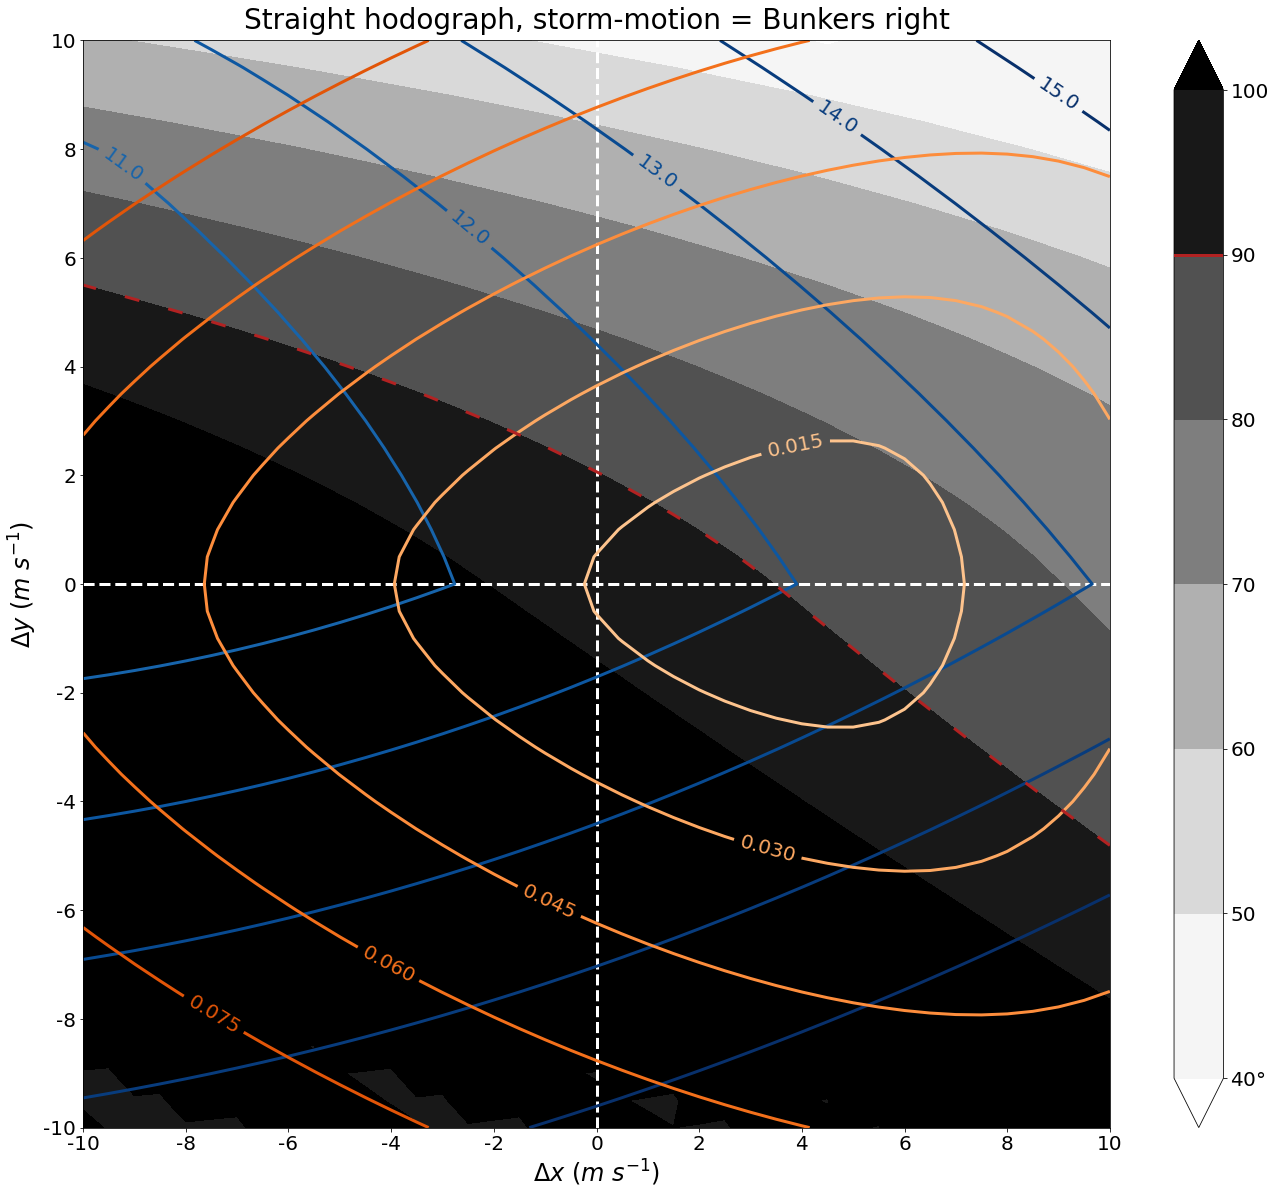

In [234]:
%matplotlib inline
rcParams['figure.figsize'] = 23,20

fig,ax = plt.subplots()

fig.patch.set_facecolor('white') 

print(np.max(angle_avg))
print(np.min(angle_avg))
print(np.max(srwind_mag_avg))
print(np.min(srwind_mag_avg))
print(np.max(hvort_mag_avg))
print(np.min(hvort_mag_avg))

levels_srwind = np.arange(11,16,1)
levels_hvort = np.arange(0.015,0.090,0.015)
levels_angle = np.arange(40,110,10)

# --- plot axes ---
plt.hlines(0,bottom,top,ls='--',colors='white',lw=3)
plt.vlines(0,left,right,ls='--',colors='white',lw=3)

# --- plot contours and fill ---
# cmap = plt.get_cmap('Greys')
# new_cmap = truncate_colormap(cmap,0.1,0.9)
cax = plt.contourf(allx,ally,angle_avg.T,cmap='Greys',levels=levels_angle,alpha=1.0,extend='both')
cbar = fig.colorbar(cax,ticks=np.arange(40,130,10))
cbarlabels = [r'40$\degree$','50','60','70','80','90','100','110','120']
cbar.ax.set_yticklabels(cbarlabels,fontsize=20)
cbar.ax.plot([40,120],[90]*2,color='firebrick',linewidth=3,zorder=20,linestyle='-')

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap,0.8,1.0)
cs1 = plt.contour(allx,ally,srwind_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_srwind)
locs = [(-9,8),(-2.5,6.5),(1.5,8),(5,9),(9,9)]
ax.clabel(cs1, inline=1, fontsize=20, fmt='%1.1f', manual=locs)

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap,0.3,0.7)
cs2 = plt.contour(allx,ally,hvort_mag_avg.T,cmap=new_cmap,linewidths=3,levels=levels_hvort)
locs = [(4,2),(3,-6),(-1,-6),(-4,-6.9),(-7,-7.2)]
ax.clabel(cs2, inline=1, fontsize=20, fmt='%1.3f', manual=locs)

# --- highlight 90 degree contour ---
plt.contour(allx,ally,angle_avg.T,levels=[90],colors='firebrick',linewidths=3,linestyles=[(0,(5,10))])

# --- edit axes labels ---
xticks = np.arange(-10,12,2)
yticks = xticks

xticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']
yticklabels = ['-10','-8','-6','-4','-2','0','2','4','6','8','10']

plt.xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=20)

plt.yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=20)

plt.xlabel(r'$\Delta x$ ($m$ $s^{-1}$)',fontsize=24)
plt.ylabel(r'$\Delta y$ ($m$ $s^{-1}$)',fontsize=24)

plt.title(r'Straight hodograph, storm-motion = Bunkers right',fontsize=28,y=1.005)

# plt.savefig('/Users/matthewflournoy/Desktop/stuff/Papers/2020-JAS-FrictionSRH/v2/figs/fig6',dpi=300)
# plt.show()
# plt.clf()




